# Reto Mercado Libre - Juliana Flores

Dentro del marketplace existen productos similares o idénticos entre sí (son productos vendidos por distintos sellers, en la api puedes obtener y descargar los títulos e incluso las imágenes!). ¿Cómo buscar dichos ítems para agruparlos y volverlos comparables entre sí? Esto permitiría mejorar la experiencia ante muchas opciones similares.

El presente notebook mostrará la solución encontrada para el caso escrito anteriormente.

Se entregan tres soluciones, un modelo **KNN de texto** con los títulos de los productos, un modelo **KNN de imágenes** con los thumbnails de cada producto y un **ensamble** sencillo que junta los resultados de los dos modelos para obtener un nuevo resultado.

>[Reto Mercado Libre - Juliana Flores](#scrollTo=dea9926d)

>>[Librerías](#scrollTo=3151528f)

>>[Recolección data](#scrollTo=041420f2)

>>[Exploración data y primera limpieza](#scrollTo=626607f1)

>>[Modelo texto](#scrollTo=ycwV2mfiGobR)

>>>[Procesamiento de texto (title)](#scrollTo=p8OPPnv1_aQY)

>>>>[Limpieza títulos](#scrollTo=pkA8oKYbjVwh)

>>>>[Pre procesamiento títulos](#scrollTo=R23UftPNjYrg)

>>>>[Vectorización de títulos](#scrollTo=DVS1QtfBrxRZ)

>>>[Modelo KNN para text embeddings](#scrollTo=BXxZoGPg-FMU)

>>[Modelo imagénes](#scrollTo=pyR2j3xGGufh)

>>>[Procesamiento de imágenes](#scrollTo=-JxJC8iZ-xbJ)

>>>>[Vectorización de imágenes](#scrollTo=EiAwOMNZrk0T)

>>>[Modelo KNN para imágenes](#scrollTo=DcUQ2AoNn_77)

>>[Ensamble modelos](#scrollTo=873f0fa3)

>[Fin del documento](#scrollTo=ivD_V7oeNHQW)



## Librerías
Se importan algunas librerías generales

In [3]:
!pip install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 197 kB 2.6 MB/s 
  Created wheel for emoji: filename=emoji-2.0.0-py3-none-any.whl size=193022 sha256=a7c807f2ed187a3e9986b96d3b4eb6d217b427840cb1054279b13292f20e0a71
  Stored in directory: /root/.cache/pip/wheels/ec/29/4d/3cfe7452ac7d8d83b1930f8a6205c3c9649b24e80f9029fc38
Successfully built emoji


In [4]:
# Generales
import pandas as pd
import numpy as np
from pandas import json_normalize
import time

# NLP
import re
import emoji

# API
import requests

In [5]:
# Para guardar directamente en drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Recolección data

In [5]:
# Carpeta en la que se guardan los outputs del notebook
path_save= '/content/gdrive/MyDrive/reto_MeLi/outputs'

In [ ]:
# Función que extrae la información desde la API por categoría de producto
def extract_info(offsets, cat):
    data = []
    country = cat[0:3]
    #for cat in categories:
    for off in offsets:
        url = f'https://api.mercadolibre.com/sites/{country}/search?category={cat}&offset={off}'
        request = requests.get(url)
        items = request.json()
        results = items['results']
            
        data = data + results
    return data
            

In [41]:
# Trae todas la categorías para Colombia
url = f'https://api.mercadolibre.com/sites/MCO/categories'
request = requests.get(url)
categorias = request.json()
categorias = json_normalize(categorias) 
categorias.head(2)

,id,name
0,MCO1747,Accesorios para Vehículos
1,MCO441917,Agro


In [ ]:
# Recolecta la data para todas la categorías en Colombia
offsets = range(0,1000, 50) 
data_completa = pd.DataFrame()
for cat in categorias['id']:
  temp_cat = extract_info(offsets, cat)
  norm_cat = json_normalize(temp_cat)
  norm_cat['id_cat'] = cat
  norm_cat['name_cat'] = categorias.loc[categorias['id']==cat, 'name']

  data_completa = pd.concat([data_completa, norm_cat])

#Guarda la base total de data
#path_save= '/content/gdrive/MyDrive/reto_MeLi/outputs'
#data_completa = pd.read_csv(path_save+'/data_cat_totales.csv')
print(data_completa.shape)
data_completa.groupby('id_cat').count()


(31006, 134)


,id,site_id,title,price,sale_price,currency_id,available_quantity,sold_quantity,buying_mode,listing_type_id,...,seller.eshop.eshop_experience,seller.eshop.eshop_locations,seller.seller_reputation.real_level,seller.seller_reputation.protection_end_date,seller.seller_reputation.metrics.cancellations.excluded.real_value,seller.seller_reputation.metrics.cancellations.excluded.real_rate,seller.seller_reputation.metrics.claims.excluded.real_value,seller.seller_reputation.metrics.claims.excluded.real_rate,seller.seller_reputation.metrics.delayed_handling_time.excluded.real_value,seller.seller_reputation.metrics.delayed_handling_time.excluded.real_rate
id_cat,,,,,,,,,,,,,,,,,,,,,
MCO1000,999,999,999,999,0,999,999,999,999,999,...,0,0,0,0,0,0,0,0,0,0
MCO1039,998,998,998,998,0,998,998,998,998,998,...,0,0,0,0,0,0,0,0,0,0
MCO1051,949,949,949,949,0,949,949,949,949,949,...,0,0,0,0,0,0,0,0,0,0
MCO1071,999,999,999,999,0,999,999,999,999,999,...,0,0,0,0,0,0,0,0,0,0
MCO1132,887,887,887,887,0,887,887,887,887,887,...,0,0,0,0,0,0,0,0,0,0
MCO1144,997,997,997,997,0,997,997,997,997,997,...,0,0,0,0,0,0,0,0,0,0
MCO1168,1000,1000,1000,1000,0,1000,1000,1000,1000,1000,...,0,0,0,0,0,0,0,0,0,0
MCO1182,1000,1000,1000,1000,0,1000,1000,1000,1000,1000,...,0,0,0,0,0,0,0,0,0,0
MCO118204,1000,1000,1000,1000,0,1000,1000,1000,1000,1000,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Arreglo nombres categorías
data_completa.drop(columns=['name_cat'], inplace=True)
#arreglo_prueba = data_completa.copy()
categorias = categorias.rename(columns={'id':'id_cat', 'name':'name_cat'})
data_completa = data_completa.merge(categorias, on='id_cat', how='left')
data_completa.head(2)

,id,site_id,title,price,sale_price,currency_id,available_quantity,sold_quantity,buying_mode,listing_type_id,...,seller.eshop.eshop_locations,seller.seller_reputation.real_level,seller.seller_reputation.protection_end_date,seller.seller_reputation.metrics.cancellations.excluded.real_value,seller.seller_reputation.metrics.cancellations.excluded.real_rate,seller.seller_reputation.metrics.claims.excluded.real_value,seller.seller_reputation.metrics.claims.excluded.real_rate,seller.seller_reputation.metrics.delayed_handling_time.excluded.real_value,seller.seller_reputation.metrics.delayed_handling_time.excluded.real_rate,name_cat
0,MCO464124554,MCO,Combo 2 Forros Protector Sillas Carro Auto Mas...,54055.0,None,COP,1,500,buy_it_now,gold_special,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Accesorios para Vehículos
1,MCO558498519,MCO,Palanca Silla Renault Twingo Clio Megane X 2...,13000.0,None,COP,1,500,buy_it_now,gold_pro,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Accesorios para Vehículos


In [6]:
#Guarda base completa para la posteridad
path_save= '/content/gdrive/MyDrive/reto_MeLi/outputs'
data_completa.to_csv(path_save+'/data_cat_totales.csv')

In [ ]:
print('Cantidad filas antes de drop duplicate: ', data_completa.shape[0])
print('Cantidad ids: ', len(data_completa.id.unique()))

Cantidad filas antes de drop duplicate:  31006
Cantidad ids:  28975


## Exploración data y primera limpieza

Se explora la data y se concluye que se van a utilizar dos tipos de data:

* Texto: Título (title).
* Imagen: Imagen pequeña (Thumbnail).

Se hace una primera limpieza de texto y se extraen atributos.

In [ ]:
df = data_completa.copy()
print('Cantidad filas antes de drop duplicate: ', df.shape[0])
print('Cantidad ids: ', len(df.id.unique()))

Cantidad filas antes de drop duplicate:  31006
Cantidad ids:  28975


In [ ]:
# Elimina rows con id duplicados
df = df.drop_duplicates(subset=['id'],keep='first').reset_index(drop=True)
print('Cantidad filas después de drop duplicate: ', df.shape[0])

Cantidad filas después de drop duplicate:  28975


In [ ]:
# Toma el atributo del producto y la asigna en la base total
df1 = df.copy()
for i in range(df1.shape[0]):
    temp_att = df1.loc[i,'attributes']
    lista_atributos = ['BRAND', 'LINE', 'WEIGHT']
    for att in lista_atributos:
        if len([item for item in temp_att if item["id"] == att])==1:
            name = [item for item in temp_att if item["id"] == att][0]['value_name']
            
        else:
            name = np.nan
        
        df1.loc[i, att.lower()] = name
    
df1.head(2)
    
    

,id,site_id,title,price,sale_price,currency_id,available_quantity,sold_quantity,buying_mode,listing_type_id,...,seller.seller_reputation.metrics.cancellations.excluded.real_value,seller.seller_reputation.metrics.cancellations.excluded.real_rate,seller.seller_reputation.metrics.claims.excluded.real_value,seller.seller_reputation.metrics.claims.excluded.real_rate,seller.seller_reputation.metrics.delayed_handling_time.excluded.real_value,seller.seller_reputation.metrics.delayed_handling_time.excluded.real_rate,name_cat,brand,line,weight
0,MCO464124554,MCO,Combo 2 Forros Protector Sillas Carro Auto Mas...,54055.0,None,COP,1,500,buy_it_now,gold_special,...,NaN,NaN,NaN,NaN,NaN,NaN,Accesorios para Vehículos,VELBROS,NaN,NaN
1,MCO558498519,MCO,Palanca Silla Renault Twingo Clio Megane X 2...,13000.0,None,COP,1,500,buy_it_now,gold_pro,...,NaN,NaN,NaN,NaN,NaN,NaN,Accesorios para Vehículos,Rvc,NaN,NaN


In [ ]:
# Crea columnas tiene_marca, tiene_peso

df1['tiene_line'] = df1.line.apply(lambda x: 0 if pd.isnull(x) else 1)
df1['tiene_peso'] = df1.weight.apply(lambda x: 0 if pd.isnull(x) else 1)
df1.head(2)

,id,site_id,title,price,sale_price,currency_id,available_quantity,sold_quantity,buying_mode,listing_type_id,...,seller.seller_reputation.metrics.claims.excluded.real_value,seller.seller_reputation.metrics.claims.excluded.real_rate,seller.seller_reputation.metrics.delayed_handling_time.excluded.real_value,seller.seller_reputation.metrics.delayed_handling_time.excluded.real_rate,name_cat,brand,line,weight,tiene_line,tiene_peso
0,MCO464124554,MCO,Combo 2 Forros Protector Sillas Carro Auto Mas...,54055.0,None,COP,1,500,buy_it_now,gold_special,...,NaN,NaN,NaN,NaN,Accesorios para Vehículos,VELBROS,NaN,NaN,0,0
1,MCO558498519,MCO,Palanca Silla Renault Twingo Clio Megane X 2...,13000.0,None,COP,1,500,buy_it_now,gold_pro,...,NaN,NaN,NaN,NaN,Accesorios para Vehículos,Rvc,NaN,NaN,0,0


In [ ]:
# Toma columnas de interés
columnas_finales = ['id', 'site_id', 'title', 'price' ,'thumbnail', 'brand', 'line', 'weight', 'tiene_line',
       'tiene_peso', 'id_cat', 'name_cat']

df_final = df1[columnas_finales]
df_final.head(2)

,id,site_id,title,price,thumbnail,brand,line,weight,tiene_line,tiene_peso,id_cat,name_cat
0,MCO464124554,MCO,Combo 2 Forros Protector Sillas Carro Auto Mas...,54055.0,http://http2.mlstatic.com/D_646062-MCO43036011...,VELBROS,NaN,NaN,0,0,MCO1747,Accesorios para Vehículos
1,MCO558498519,MCO,Palanca Silla Renault Twingo Clio Megane X 2...,13000.0,http://http2.mlstatic.com/D_926680-MCO41388127...,Rvc,NaN,NaN,0,0,MCO1747,Accesorios para Vehículos


In [ ]:
df_process = df_final.copy()

In [ ]:
# Funciones generales

def preprocess_text(sentence, options = [1 for i in range(9)]):
    # Minúsculas
    if options[0]:
        sentence = sentence.lower()
    # Hard space html
    if options[1]:
        sentence = re.sub("\\xa0", " ", sentence)
    # Delete URLs
    if options[2]:
        sentence = re.sub("(http|www)\S+"," ", sentence)
    # Delete users and hashtags (All the word)
    if options[3]:
        sentence = re.sub("@\S+", " ", sentence)
        sentence = re.sub("#\S+", " ", sentence)
    # Elimina emojis
    if options[4]:
        sentence = emoji.replace_emoji(sentence)
        #sentence = emoji.demojize(sentence, language = "es")
    # Delete punctuation and rare characters
    if options[5]:
        sentence = re.sub('[^a-zA-Zñáéíóúü_0-9]', ' ', sentence)
    # White space removal
    if options[6]:
        sentence = re.sub("\\s+", ' ', sentence)
    # Repeated words with and without spaces
    if options[7]:
        sentence = re.sub(r'\b(.+)\b\1+', r' \1', sentence)
    # Strip
    if options[8]:
        sentence = sentence.strip()
    return sentence




# Convierte columna/s a lower case
def limpieza_columnas_texto(df, columnas):
    for col in columnas:
        #print(col)
        df[col] = df[col].apply( lambda sentence: preprocess_text(sentence))
        
        
# Convierte columnas a str
def to_string(df, columnas):
    for col in columnas:
        #print(col)
        df[col] = df[col].astype(str)
   


In [ ]:
#Crea columna de número del peso
df_process['weight_number'] = df_process.weight.str.extract('(\d+)')

In [ ]:
df_process = df_process.fillna(value=np.nan)
columnas_texto = ['title', 'brand', 'line', 'weight']
to_string(df_process, columnas_texto)
# Limpia columnas de texto
limpieza_columnas_texto(df_process, columnas_texto)
df_process.head(2)

,id,site_id,title,price,thumbnail,brand,line,weight,tiene_line,tiene_peso,id_cat,name_cat,weight_number
0,MCO464124554,MCO,combo 2 forros protector sillas carro auto mas...,54055.0,http://http2.mlstatic.com/D_646062-MCO43036011...,velbros,nan,nan,0,0,MCO1747,Accesorios para Vehículos,NaN
1,MCO558498519,MCO,palanca silla renault twingo clio megane x 2 c...,13000.0,http://http2.mlstatic.com/D_926680-MCO41388127...,rvc,nan,nan,0,0,MCO1747,Accesorios para Vehículos,NaN


In [ ]:
#Normaliza acentos de columnas de texto
df_process[columnas_texto] = df_process[columnas_texto].apply(lambda x: x.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8'))
df_process.head(2)

,id,site_id,title,price,thumbnail,brand,line,weight,tiene_line,tiene_peso,id_cat,name_cat,weight_number
0,MCO464124554,MCO,combo 2 forros protector sillas carro auto mas...,54055.0,http://http2.mlstatic.com/D_646062-MCO43036011...,velbros,nan,nan,0,0,MCO1747,Accesorios para Vehículos,NaN
1,MCO558498519,MCO,palanca silla renault twingo clio megane x 2 c...,13000.0,http://http2.mlstatic.com/D_926680-MCO41388127...,rvc,nan,nan,0,0,MCO1747,Accesorios para Vehículos,NaN


In [ ]:
# Revisión unidade de peso
set([re.sub('[^a-zA-Zñáéíóúü]+', '', s) for s in df_process['weight'].unique()])

{'g', 'kg', 'lb', 'mg', 'nan', 'oz'}

In [ ]:
# Estandarización de pesos (a g)
df_process['weight_number'] = df_process['weight_number'].astype('float')
def convert_weight_to_g(df, weight_column_number, weight_column_str):
    # De kg a gramos
    df.loc[df[weight_column_str].str.contains('kg'), 'weight_gram'] = df.loc[df[weight_column_str].str.contains('kg'), 'weight_number']*1000
    # De lb a gramos
    df.loc[df[weight_column_str].str.contains('lb'), 'weight_gram'] = df.loc[df[weight_column_str].str.contains('lb'), 'weight_number']*453.592
    # De oz a gramos
    df.loc[df[weight_column_str].str.contains('oz'), 'weight_gram'] = df.loc[df[weight_column_str].str.contains('oz'), 'weight_number']*28.3495
    # De mg a gramos
    df.loc[df[weight_column_str].str.contains('mg'), 'weight_gram'] = df.loc[df[weight_column_str].str.contains('mg'), 'weight_number']/1000
    
    
convert_weight_to_g(df_process, 'weight_number', 'weight')
df_process.head(2)


,id,site_id,title,price,thumbnail,brand,line,weight,tiene_line,tiene_peso,id_cat,name_cat,weight_number,weight_gram
0,MCO464124554,MCO,combo 2 forros protector sillas carro auto mas...,54055.0,http://http2.mlstatic.com/D_646062-MCO43036011...,velbros,nan,nan,0,0,MCO1747,Accesorios para Vehículos,NaN,NaN
1,MCO558498519,MCO,palanca silla renault twingo clio megane x 2 c...,13000.0,http://http2.mlstatic.com/D_926680-MCO41388127...,rvc,nan,nan,0,0,MCO1747,Accesorios para Vehículos,NaN,NaN


In [ ]:
# Revisión rápida de distribución de pesos por categoría
import plotly.express as px
fig = px.box(df_process, y="weight_gram", facet_col='name_cat')
fig.show()

In [ ]:
# Revisión rápida de distribución de precios por categoría
fig = px.box(df_process, y="price", facet_col='name_cat')
fig.show()

In [ ]:
# Crea df con index y id para futuros encuentros 
#df_index_id = df_process.reset_index()[['index', 'id']]
#df_index_id.to_csv(path_save+'/id_index.csv')


## Modelo texto

En este sección se limpian y procesan los títulos para el modelo (vectorizan), se genera finalmente un modelo KNN que recomienda los n productos más cercanos para cada producto en la base general y luego se revisa el modelo para categorías.

### Procesamiento de texto (title)
Se entranará un modelo de word2vec para vectorizar los títulos.

#### Limpieza títulos

In [ ]:
# Numerical value removal
def numerical_removal(sentence):
    sentence = re.sub("\d+", ' ', sentence)
    return sentence

# Se retiran los número de los títulos después de hacer exploración con números
df_process["clean_title"] = df_process["title"].apply(lambda sen: numerical_removal(sen))

df_process = df_process[df_process['clean_title'] !=' '].reset_index(drop=True)

#Guarda la base con la limpieza hecha hasta el momento
print(df_process.shape)
df_process.to_csv(path_save + '/df_processed.csv')

(28974, 15)


#### Pre procesamiento títulos

In [ ]:
# Se tokenizan lo títulos
import nltk
nltk.download('punkt')
nltk.download('stopwords')

all_sentences = df_process["clean_title"].apply(lambda s:nltk.sent_tokenize(s))
all_words = [nltk.word_tokenize(t) for sent in all_sentences for t in sent]

# Se eliminan stop words en español
stopword_es = nltk.corpus.stopwords.words('spanish')
special_SW = ["."]
stopwords = stopword_es + special_SW
for i in range(len(all_words)):
    all_words[i] = [w for w in all_words[i] if w not in stopwords]

# Se aplica Stemmming (no lemmatizacion por tiempo)
from nltk.stem import SnowballStemmer
stemming = True
spanishStemmer = SnowballStemmer('spanish')

if stemming:
    for i in range(len(all_words)):
        all_words[i] = [spanishStemmer.stem(w) for w in all_words[i]]

all_words[0]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


['comb', 'forr', 'protector', 'sill', 'carr', 'aut', 'mascot', 'perr']

In [ ]:
# Se guarda en base respectivo título_clean con su stem título
all_sentences_flatten = df_process["clean_title"]
df_stem_title = pd.DataFrame()
df_stem_title['clean_title'] = all_sentences_flatten
df_stem_title['stem_title'] = all_words
#Guarda base para la posteridad
#path_save= '/content/gdrive/MyDrive/reto_MeLi/outputs'
#df_stem_title.to_csv(path_save+'/data_clean_stem_title.csv')
df_stem_title

,clean_title,stem_title
0,combo forros protector sillas carro auto mas...,"[comb, forr, protector, sill, carr, aut, masco..."
1,palanca silla renault twingo clio megane x c...,"[palanc, sill, renault, twing, cli, megan, x, ..."
2,carpa pijama semi impermeable para moto con ar...,"[carp, pijam, semi, imperm, mot, argoll, metal]"
3,radio para carro jdl con usb bluetooth y le...,"[radi, carr, jdl, usb, bluetooth, lector, tarj..."
4,pato para carro moto bicicleta accesorio de lujo,"[pat, carr, mot, biciclet, accesori, luj]"
...,...,...
28969,grip desechable puntera y tubo tatuaje tatto...,"[grip, desech, punter, tub, tatuaj, tatto, tat..."
28970,amazing herbs premium black seed oil fluid o...,"[amazing, herbs, premium, black, seed, oil, fl..."
28971,hornet king size conos clasico rolling paper c...,"[hornet, king, siz, con, clasic, rolling, pap,..."
28972,bricket encendedor a gas llavero monedas un do...,"[bricket, encendedor, gas, llaver, moned, dol,..."


In [ ]:
# Revisión cantidad de títulos en bases y vectores de sentences
print(len(all_words), df_process.shape, len(all_sentences))

28974 (28974, 15) 28974


#### Vectorización de títulos

Dada la cantidad de títulos que se tienen, se considera que se puede entrenar un **word2vec** (en vez de utilizar un modelo pre-entrenado) para así vectorizar las palabras que aparecen en los títulos de los productos.

Se pruebas distintos windows, un window grande captura más sobre temática, uno más pequeño entiende mas cada palabra y a qué otras palabras se parecen. Después de varias iteraciones y sus respectivas revisiones se escoge **window 5**.

In [ ]:
# Entrenamiento modelo word2vec con 100 dimensiones
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

model = Word2Vec(   all_words,  # Sentences
                    size = 100,  # Dimensionality
                    window = 5,  # Maximum distance between current and predicted word
                    min_count = 1,  # Ignore words with lower frequency than this
                    sg = 1,  # 1: Skip-gram, 0: CBOW
                )

In [ ]:
# Revisión palabras más parecidas según word2vec entrenado
pal = 'smart'
model.wv.most_similar(pal, topn=10)


[('televisor', 0.9115604162216187),
 ('andro', 0.908488392829895),
 ('crystal', 0.9052348732948303),
 ('au', 0.9043372869491577),
 ('ai', 0.9041008949279785),
 ('tv', 0.9007269740104675),
 ('plus', 0.9000946283340454),
 ('mpx', 0.8981214761734009),
 ('tablet', 0.8922044038772583),
 ('qn', 0.8920427560806274)]

In [ ]:
# Revisión palabras más parecidas según word2vec entrenado
pal = 'pc'
model.wv.most_similar(pal, topn=10)

[('comput', 0.9025667309761047),
 ('torr', 0.8874397277832031),
 ('monitor', 0.8866869211196899),
 ('cpu', 0.8807779550552368),
 ('mades', 0.873979926109314),
 ('vga', 0.872025728225708),
 ('cors', 0.871288537979126),
 ('gaming', 0.8712809681892395),
 ('gc', 0.8710399866104126),
 ('veint', 0.8688316941261292)]

In [ ]:
# Revisión palabras más parecidas según word2vec entrenado
pal = 'comput'
model.wv.most_similar(pal, topn=10)

[('monitor', 0.9460738897323608),
 ('torr', 0.9354214668273926),
 ('gaming', 0.9339709877967834),
 ('cpu', 0.932581901550293),
 ('laptop', 0.9252651929855347),
 ('tuf', 0.9229738116264343),
 ('dell', 0.9188668727874756),
 ('ryzen', 0.9166642427444458),
 ('curv', 0.9159471392631531),
 ('amd', 0.9158320426940918)]

In [ ]:
path_save= '/content/gdrive/MyDrive/reto_MeLi/outputs'
word_vectors = model.wv
word_vectors.save(path_save+"/Stem_Skip-Gram_with_analisis_100dim.wordvectors")

In [ ]:
# Se crea dictionario con representación vectorial de cada palabra
w2v = {w: vec for w, vec in zip(model.wv.index2word, model.wv.syn0)}

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  


Se decide tomar como embedding de cada título el promedio de los embeddings de las palabras que lo conforman, esto gracias a investigación y dado que se tiene una dimensión alta (100), lo que hace que dos títulos con palabras muy distintas tengan promedios muy distintos.

In [ ]:
# Se crea lista promedio de emmbeddings de cada palabra para cada título
list_means = list()
for sentence in all_words:
  list_vecs = [w2v[k] for k in sentence]
  mean =  np.mean(list_vecs, axis=0)
  list_means.append(mean)

In [ ]:
# Se crea base con los promedios de palabras
df_stem_mean_vec = pd.DataFrame()
df_stem_mean_vec['stem_title'] = all_words
df_stem_mean_vec['mean_vec'] = list_means

df_stem_mean_vec

,stem_title,mean_vec
0,"[comb, forr, protector, sill, carr, aut, masco...","[-0.18918867, 0.10683069, -0.43002185, 0.02303..."
1,"[palanc, sill, renault, twing, cli, megan, x, ...","[-0.22224791, 0.07983734, -0.21728449, -0.0249..."
2,"[carp, pijam, semi, imperm, mot, argoll, metal]","[-0.11463611, 0.0676013, -0.2408954, -0.129429..."
3,"[radi, carr, jdl, usb, bluetooth, lector, tarj...","[-0.5159287, -0.09035997, -0.20237277, -0.0016..."
4,"[pat, carr, mot, biciclet, accesori, luj]","[-0.28086844, -0.009920113, -0.32153827, -0.09..."
...,...,...
28969,"[grip, desech, punter, tub, tatuaj, tatto, tat...","[0.05452598, 0.09261336, -0.28235874, -0.02737..."
28970,"[amazing, herbs, premium, black, seed, oil, fl...","[-0.114630885, 0.07117588, -0.1740684, 0.00592..."
28971,"[hornet, king, siz, con, clasic, rolling, pap,...","[-0.07261444, 0.10905945, -0.23459642, -0.0160..."
28972,"[bricket, encendedor, gas, llaver, moned, dol,...","[-0.08870603, -0.024144756, -0.12259008, -0.07..."


In [ ]:
df_stem_title_mean_vec = df_stem_title.merge(df_stem_mean_vec, left_index=True, right_index=True, how='left')
df_stem_title_mean_vec.to_csv(path_save+'/data_clean_stem_title_mean_vec.csv', index=False)

In [ ]:
df_stem_title_mean_vec.head(2)

,clean_title,stem_title_x,stem_title_y,mean_vec
0,combo forros protector sillas carro auto mas...,"[comb, forr, protector, sill, carr, aut, masco...","[comb, forr, protector, sill, carr, aut, masco...","[-0.18918867, 0.10683069, -0.43002185, 0.02303..."
1,palanca silla renault twingo clio megane x c...,"[palanc, sill, renault, twing, cli, megan, x, ...","[palanc, sill, renault, twing, cli, megan, x, ...","[-0.22224791, 0.07983734, -0.21728449, -0.0249..."


In [ ]:
# Se crea y guarda base con los embeddings para cada título en la base total

data_vectores_texto = pd.DataFrame(list_means)
data_vectores_texto.columns = ['emb_text_'+str(col) for col in data_vectores_texto.columns]
data_vectores_texto['id'] = df_process['id']
data_vectores_texto= data_vectores_texto.set_index('id')
print(data_vectores_texto.shape)
data_vectores_texto.to_csv(path_save+'/text_embedding_100_dim.csv', index=False)
data_vectores_texto.head(2)

(28974, 100)


,emb_text_0,emb_text_1,emb_text_2,emb_text_3,emb_text_4,emb_text_5,emb_text_6,emb_text_7,emb_text_8,emb_text_9,...,emb_text_90,emb_text_91,emb_text_92,emb_text_93,emb_text_94,emb_text_95,emb_text_96,emb_text_97,emb_text_98,emb_text_99
id,,,,,,,,,,,,,,,,,,,,,
MCO464124554,-0.189189,0.106831,-0.430022,0.023039,0.081307,0.121745,-0.160853,0.104152,-0.044718,-0.513232,...,-0.514026,0.350608,0.045329,0.459717,-0.227573,-0.448869,0.160051,0.012156,0.009415,0.208595
MCO558498519,-0.222248,0.079837,-0.217284,-0.024935,0.004926,0.109555,0.010615,0.159796,0.058979,-0.329285,...,-0.275685,0.153714,0.042795,0.274347,-0.118790,-0.272345,0.311035,-0.001581,0.080297,0.244076


In [6]:
################## Lectura intermedia de df_process ##################
path_save= '/content/gdrive/MyDrive/reto_MeLi/outputs'
df_process = pd.read_csv(path_save + '/df_processed.csv')
df_process = df_process.drop(columns=['Unnamed: 0'])
df_process.head()

,id,site_id,title,price,thumbnail,brand,line,weight,tiene_line,tiene_peso,id_cat,name_cat,weight_number,weight_gram,clean_title
0,MCO464124554,MCO,combo 2 forros protector sillas carro auto mas...,54055.0,http://http2.mlstatic.com/D_646062-MCO43036011...,velbros,NaN,NaN,0,0,MCO1747,Accesorios para Vehículos,NaN,NaN,combo forros protector sillas carro auto mas...
1,MCO558498519,MCO,palanca silla renault twingo clio megane x 2 c...,13000.0,http://http2.mlstatic.com/D_926680-MCO41388127...,rvc,NaN,NaN,0,0,MCO1747,Accesorios para Vehículos,NaN,NaN,palanca silla renault twingo clio megane x c...
2,MCO559508714,MCO,carpa pijama semi impermeable para moto con ar...,30900.0,http://http2.mlstatic.com/D_609767-MCO48895331...,lavef,NaN,NaN,0,0,MCO1747,Accesorios para Vehículos,NaN,NaN,carpa pijama semi impermeable para moto con ar...
3,MCO865524965,MCO,radio para carro jdl 5303 con usb bluetooth y...,90900.0,http://http2.mlstatic.com/D_799836-MLA48110981...,jdl,NaN,NaN,0,0,MCO1747,Accesorios para Vehículos,NaN,NaN,radio para carro jdl con usb bluetooth y le...
4,MCO844377861,MCO,pato para carro moto bicicleta accesorio de lujo,17000.0,http://http2.mlstatic.com/D_620298-MCO49130427...,generica,NaN,NaN,0,0,MCO1747,Accesorios para Vehículos,NaN,NaN,pato para carro moto bicicleta accesorio de lujo


In [7]:
################## Lectura intermedia de embedding de texto ##################
path_save= '/content/gdrive/MyDrive/reto_MeLi/outputs'
data_vectores_texto = pd.read_csv(path_save+'/text_embedding_100_dim.csv')
print(data_vectores_texto.shape)
data_vectores_texto.head()

(28974, 100)


,emb_text_0,emb_text_1,emb_text_2,emb_text_3,emb_text_4,emb_text_5,emb_text_6,emb_text_7,emb_text_8,emb_text_9,...,emb_text_90,emb_text_91,emb_text_92,emb_text_93,emb_text_94,emb_text_95,emb_text_96,emb_text_97,emb_text_98,emb_text_99
0,-0.189189,0.106831,-0.430022,0.023039,0.081307,0.121745,-0.160853,0.104152,-0.044718,-0.513232,...,-0.514026,0.350608,0.045329,0.459717,-0.227573,-0.448869,0.160051,0.012156,0.009415,0.208595
1,-0.222248,0.079837,-0.217284,-0.024935,0.004926,0.109555,0.010615,0.159796,0.058979,-0.329285,...,-0.275685,0.153714,0.042795,0.274347,-0.118790,-0.272345,0.311035,-0.001581,0.080297,0.244076
2,-0.114636,0.067601,-0.240895,-0.129430,-0.078243,0.366778,0.003104,0.022752,-0.087840,-0.465406,...,-0.325658,0.143666,0.061943,0.202950,-0.271713,-0.314815,0.033483,-0.014757,0.001367,0.089284
3,-0.515929,-0.090360,-0.202373,-0.001683,0.066136,0.156287,-0.099200,0.317456,-0.123010,-0.550175,...,-0.338025,0.373523,0.526897,0.250146,-0.219884,-0.410217,-0.058580,-0.196854,0.120740,0.441295
4,-0.280868,-0.009920,-0.321538,-0.099422,-0.104355,0.243503,0.173989,0.076403,-0.192587,-0.511844,...,-0.304880,0.238389,0.186130,0.256128,-0.308280,-0.242762,0.042929,-0.044356,0.102670,0.077878


### Modelo KNN para text embeddings
Se buscarán los n vecinos más cercanos de cada título sobre los embeddings de los textos.

In [8]:
# Función que itera knn sobre distintas métricas y algoritmos para encontrar los vecinos más cercanos
from sklearn.neighbors import NearestNeighbors
def knn_fit(metric, algorithm, k_neighbors, df):
  start_time = time.time()
  knn_text = NearestNeighbors(n_neighbors=k_neighbors,
                              metric=metric,
                              algorithm=algorithm,
                              n_jobs=-1)
  neighs_text = knn_text.fit(df)
  distances_text, indices_text = neighs_text.kneighbors(df)
  indices_text_new = [np.delete(indices_text[ind], (indices_text[ind]==ind).argmax()) for ind in range(len(indices_text))]
  distances_text_new = [np.delete(distances_text[ind], (indices_text[ind]==ind).argmax()) for ind in range(len(distances_text))]
  print("--- %s seconds ---" % (time.time() - start_time), metric, algorithm)
  return indices_text_new, distances_text_new

In [58]:
# Función que imprime accuracy del de categorías por vecino indicado en parámetro
import sklearn
from sklearn.preprocessing import StandardScaler
#from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
def print_metrics(df,num_neigh, indices_model):
  y_test = df['name_cat']
  indices_neigh = [ind[num_neigh] for ind in indices_model]
  y_pred = [df.loc[indice,'name_cat'] for indice in indices_neigh]
  #print(f'Precision neigh {num_neigh}: %.3f' % precision_score(y_test, y_pred,average='micro'))
  #print(f'Recall neigh {num_neigh}: %.3f' % recall_score(y_test, y_pred, average='micro'))	
  print(f'Accuracy neigh {num_neigh}: %.3f' % accuracy_score(y_test, y_pred))

In [ ]:
# Imprime tiempo y accuracy de cada knn entrenado con métrica y algoritmo distinto
metrics = ['cityblock', 'cosine', 'euclidean', 'haversine', 'l2', 'l1', 'manhattan']
algs = ['ball_tree', 'kd_tree', 'brute']
start_time_tot = time.time()
k_neighbors = 4
df= data_vectores_texto
for algorithm in algs:
  for metric in metrics:
    try:
      indices, distances = knn_fit(metric, algorithm, k_neighbors, df)
      for i in range(3):
        print_metrics(df_process,i, indices)
    except:
      pass

print("--- %s seconds ---" % (time.time() - start_time_tot))



--- 106.21607708930969 seconds --- cityblock ball_tree
Accuracy neigh 0: 0.704
Accuracy neigh 1: 0.650
Accuracy neigh 2: 0.613
--- 101.11958074569702 seconds --- euclidean ball_tree
Accuracy neigh 0: 0.705
Accuracy neigh 1: 0.650
Accuracy neigh 2: 0.617
--- 88.75283026695251 seconds --- l2 ball_tree
Accuracy neigh 0: 0.705
Accuracy neigh 1: 0.650
Accuracy neigh 2: 0.617
--- 91.02964186668396 seconds --- l1 ball_tree
Accuracy neigh 0: 0.704
Accuracy neigh 1: 0.650
Accuracy neigh 2: 0.613
--- 88.70843744277954 seconds --- manhattan ball_tree
Accuracy neigh 0: 0.704
Accuracy neigh 1: 0.650
Accuracy neigh 2: 0.613
--- 86.81947588920593 seconds --- cityblock kd_tree
Accuracy neigh 0: 0.705
Accuracy neigh 1: 0.650
Accuracy neigh 2: 0.613
--- 45.80037307739258 seconds --- euclidean kd_tree
Accuracy neigh 0: 0.705
Accuracy neigh 1: 0.650
Accuracy neigh 2: 0.618
--- 48.266276597976685 seconds --- l2 kd_tree
Accuracy neigh 0: 0.705
Accuracy neigh 1: 0.650
Accuracy neigh 2: 0.618
--- 85.409899950

In [32]:
# Se escoge metric cosine y algorithm brute por mayor accuracy, menor tiempo e investigación sobre knn en texto.
import pickle
start_time = time.time()
k_neighbors=4 # Si se quieren n vecinos, se debe escoger n+1
metric = 'cosine'
algorithm='brute'
knn_text = NearestNeighbors(n_neighbors=k_neighbors,
                         metric=metric,
                         algorithm=algorithm,
                         n_jobs=-1)
neighs_text = knn_text.fit(data_vectores_texto)
distances_text, indices_text = neighs_text.kneighbors(data_vectores_texto)
# Se quitan los indices y distancias de sí mismos
indices_text_new = [np.delete(indices_text[ind], (indices_text[ind]==ind).argmax()) for ind in range(len(indices_text))]
distances_text_new = [np.delete(distances_text[ind], (indices_text[ind]==ind).argmax()) for ind in range(len(distances_text))]

# Se guardan índices y distancias
pd.DataFrame(indices_text_new).to_csv(path_save + f'/models/indices_knn_text_{k_neighbors-1}_{metric}_{algorithm}.csv')
pd.DataFrame(distances_text_new).to_csv(path_save + f'/models/distances_knn_text_{k_neighbors-1}_{metric}_{algorithm}.csv')

# Se guarda modelo
filename = path_save+f'/models/knn_text_{k_neighbors-1}_{metric}_{algorithm}.sav'
pickle.dump(neighs_text, open(filename, 'wb'))

print("--- %s seconds ---" % (time.time() - start_time))

--- 25.681562900543213 seconds ---


In [ ]:
# Guarda las métricas del modelo
def guardar_metricas_modelo(num_neighs,indices_model, nombre_modelo):
  metricas = pd.DataFrame()
  y_test = df_process['name_cat']
  metricas.loc[0, 'modelo'] = nombre_modelo
  for num_neigh in range(num_neighs):
    indices_neigh = [ind[num_neigh] for ind in indices_model]
    y_pred = [df_process.loc[indice,'name_cat'] for indice in indices_neigh]
    accuracy = accuracy_score(y_test, y_pred)
    metricas.loc[0, f'acc_{num_neigh}'] = accuracy
  metricas.to_csv(path_save+f'/models/metricas_{nombre_modelo}.csv')

nombre_modelo = f'knn_text_{k_neighbors-1}_{metric}_{algorithm}'
guardar_metricas_modelo(k_neighbors-1,indices_text_new, nombre_modelo)
  


In [ ]:
# Se guarda base con los resultados de los 3 vecinos más cercanos para cada título

def resultados_knn_text(df_total, indices_modelo, distancias_modelo, 
                        title=1, # 1 si se quiere agregar título a la base, 0 si no.
                        categoria=1, # 1 si se quiere agregar categoría a la base, 0 si no.
                        imagen =1):# 1 si se quiere agregar imagen a la base, 0 si no.
  data_temp_tit = df_total[['id', 'title','id_cat','name_cat', 'thumbnail']]
  for ind in range(len(indices_modelo)):
    indices_knn = indices_modelo[ind]
    for idx,neigh in enumerate(indices_knn):
      id_neigh = df_total.loc[neigh, 'id']
      data_temp_tit.loc[ind, f'id_knn_{idx}'] = id_neigh
      data_temp_tit.loc[ind, f'distance_knn_{idx}'] = distancias_modelo[ind][idx]
      if title == 1:
        title_neigh = df_total.loc[neigh, 'title']
        data_temp_tit.loc[ind, f'title_knn_{idx}'] = title_neigh
      if categoria == 1:
        cat_neigh = df_total.loc[neigh, 'name_cat']
        data_temp_tit.loc[ind, f'cat_knn_{idx}'] = cat_neigh
      if imagen == 1:
        pic_neigh = df_total.loc[neigh, 'thumbnail']
        data_temp_tit.loc[ind, f'img_knn_{idx}'] = pic_neigh

  return data_temp_tit
      
resultados_text = resultados_knn_text(df_process, indices_text_new, distances_text_new, title=1, categoria=1, imagen =1) 
# Guarda para la posteridad
resultados_text.to_csv(path_save +f'/models/resultados_{nombre_modelo}.csv', index=False) 
resultados_text.head()  


Revisión de resultados de categorías por categoría en *Tableau*.

In [10]:
# Función que busca los índices de la base total de categoría deseada 
def indices_categoria_total(df_total, categoria):
  indices = df_total[df_total['id_cat'] == categoria].index
  return indices

# Función que toma embeddings de texto para indices de categoria
def embeddings_texto_categoria(df_embeddings, df_total,categoria):
  indices = indices_categoria_total(df_total, categoria)
  emb_cat = df_embeddings.loc[indices]
  return emb_cat

In [45]:
categorias_dict = pd.Series(categorias.name.values,index=categorias.id).to_dict()
categorias_dict

{'MCO1747': 'Accesorios para Vehículos',
 'MCO441917': 'Agro',
 'MCO1403': 'Alimentos y Bebidas',
 'MCO1071': 'Animales y Mascotas',
 'MCO1367': 'Antigüedades y Colecciones',
 'MCO1368': 'Arte, Papelería y Mercería',
 'MCO1384': 'Bebés',
 'MCO1246': 'Belleza y Cuidado Personal',
 'MCO40433': 'Boletas para Espectáculos',
 'MCO1039': 'Cámaras y Accesorios',
 'MCO1743': 'Carros, Motos y Otros',
 'MCO1051': 'Celulares y Teléfonos',
 'MCO1648': 'Computación',
 'MCO1144': 'Consolas y Videojuegos',
 'MCO172890': 'Construcción',
 'MCO1276': 'Deportes y Fitness',
 'MCO5726': 'Electrodomésticos',
 'MCO1000': 'Electrónica, Audio y Video',
 'MCO175794': 'Herramientas',
 'MCO1574': 'Hogar y Muebles',
 'MCO1499': 'Industrias y Oficinas',
 'MCO1459': 'Inmuebles',
 'MCO1182': 'Instrumentos Musicales',
 'MCO1132': 'Juegos y Juguetes',
 'MCO3025': 'Libros, Revistas y Comics',
 'MCO1168': 'Música, Películas y Series',
 'MCO118204': 'Recuerdos, Piñatería y Fiestas',
 'MCO3937': 'Relojes y Joyas',
 'MCO143

In [75]:
# Búsqueda de vecinos dentro de cada categoría Electrónica, Audio y Video
id_cat = 'MCO1000'
emb_prueba = embeddings_texto_categoria(data_vectores_texto, df_process,id_cat)

mod_cat_text = knn_text.fit(emb_prueba)
dist_prueba, ind_prueba = mod_cat_text.kneighbors(emb_prueba)

ind_prueba_new = [np.delete(ind_prueba[ind], (ind_prueba[ind]==ind).argmax()) for ind in range(len(ind_prueba))]
dist_prueba_new = [np.delete(dist_prueba[ind], (ind_prueba[ind]==ind).argmax()) for ind in range(len(dist_prueba))]

base_cat = df_process[df_process['id_cat']==id_cat].reset_index(drop=True)
resultdos_prueba = resultados_knn_text(base_cat, ind_prueba_new, dist_prueba_new, title=1, categoria=0, imagen =1) 
#resultdos_prueba = resultdos_prueba[resultdos_prueba['id_knn_0'].notna()]
print(resultdos_prueba.shape)
# Revision muestra 50 predicciones
pd.options.display.max_colwidth = 100
resultdos_prueba.head(50)[['title', 'title_knn_0', 'title_knn_1']]

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(980, 17)


,title,title_knn_0,title_knn_1
0,audifonos in ear inalambricos xiaomi redmi airdots negro,audifonos in ear inalambricos xiaomi redmi airdots 3 azul,audifonos in ear inalambricos xiaomi redmi buds 3 blanco
1,smart tv samsung series 5 un40t5290akxzl led full hd 40 100v 240v,smart tv samsung series 5 un43t5300akxzl led full hd 43 100v 240v,smart tv samsung series 5 un43t5300afxzx led full hd 43 110v 127v
2,audifonos in ear inalambricos f9 5 negro,audifonos in ear inalambricos f9 negro,audifonos in ear inalambricos motorola vervebuds 100 negro
3,smart tv hyundai hyled3248aim hd 32 220v,smart tv hyundai hyled3243nim hd 32 110v,smart tv hyundai hyled4321aim full hd 43 100v 200v
4,audifonos in ear gamer inalambricos xiaomi redmi airdots 2 negro,audifonos in ear gamer inalambricos xiaomi redmi airdots 2 blanco,audifonos in ear gamer inalambricos xiaomi redmi buds 3 lite negro
5,amazon echo dot 4th gen con asistente virtual alexa charcoal 110v 240v,amazon echo dot 3rd gen con asistente virtual alexa charcoal 110v 240v,amazon echo 4th gen con asistente virtual alexa charcoal 110v 240v
6,google chromecast 3 generacion full hd carbon,roku express 3930 se estandar full hd 32mb con 512mb,televisor caixun 32 c32v1hn full hd smart
7,roku express 4k 3941 de voz 4k negro,roku express 4k 3940 estandar 4k negro,roku premiere 3920 estandar 4k negro
8,audifonos in ear jbl tune 110 black,audifonos in ear kz zsx black,audifonos in ear inalambricos jbl tune 225tws black
9,amazon fire tv stick lite de voz full hd 8gb negro con 1gb de memoria ram,amazon fire tv stick 3 generacion de voz full hd 8gb negro con 1gb de memoria ram,amazon fire tv stick 2 generacion de voz full hd 8gb negro con 1gb de memoria ram


In [76]:
# Búsqueda de vecinos dentro de cada categoría inmuebles
id_cat = 'MCO1459'
emb_prueba = embeddings_texto_categoria(data_vectores_texto, df_process,id_cat)

mod_cat_text = knn_text.fit(emb_prueba)
dist_prueba, ind_prueba = mod_cat_text.kneighbors(emb_prueba)

ind_prueba_new = [np.delete(ind_prueba[ind], (ind_prueba[ind]==ind).argmax()) for ind in range(len(ind_prueba))]
dist_prueba_new = [np.delete(dist_prueba[ind], (ind_prueba[ind]==ind).argmax()) for ind in range(len(dist_prueba))]

base_cat = df_process[df_process['id_cat']==id_cat].reset_index(drop=True)
resultdos_prueba = resultados_knn_text(base_cat, ind_prueba_new, dist_prueba_new, title=1, categoria=0, imagen =1) 
#resultdos_prueba = resultdos_prueba[resultdos_prueba['id_knn_0'].notna()]
print(resultdos_prueba.shape)
# Revision muestra 50 predicciones
pd.options.display.max_colwidth = 100
resultdos_prueba.head(50)[['title', 'title_knn_0', 'title_knn_1']]

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(1000, 17)


,title,title_knn_0,title_knn_1
0,apartamento en la verde 2 habitaciones 42 m,apartamento en ciudad verde 3 habitaciones 43 m,apartamento en ciudad verde 2 habitaciones 45 m
1,venta de espectacular penthouse poblado para estrenar con jacuzzi,venta finca en jardin antioquia vereda verdum,venta penthouse en la julita pereira
2,venta apartamento san antonio de prado,venta apartamento itagui san gabriel,apartamento en venta en las palmas poblado
3,apartamento en union la flora 3 habitaciones 53 m,apartamento en la flora el rincon 3 habitaciones 103 m,apartamento en bella suiza 3 habitaciones 111 m
4,casa en barrio santa fe 5 habitaciones 167 m,casa en urbanizacion villa sajonia 6 habitaciones 216 m,casa en ciudadela primavera calandaima 4 habitaciones 120 m
5,casa en perpetuo socorro 7 habitaciones 60 m,casa en samaria 4 habitaciones 270 m,casa en tibabita 4 habitaciones 108 m
6,apartamento en la rosita 2 habitaciones 20 m,apartamento en la valvanera 2 habitaciones 42 m,apartamento en baquero 2 habitaciones 81 m
7,apartamento en santa barbara central 3 habitaciones 120 m,apartamento en santa barbara central 2 habitaciones 88 m,apartamento en santa barbara central 2 habitaciones 78 m
8,casa en colina campestre niza 4 habitaciones 180 m,casa en barrio belen la gloria 3 habitaciones 102 m,casa en loma de las brujas 4 habitaciones 400 m
9,apartamento en venta edificio moratto p h itaguih b,apartamento en venta edificio moratto p h itaguih b,apartamento en venta edificio monteflor p h sabanetah b


In [77]:
# Búsqueda de vecinos dentro de cada categoría Cámaras y Accesorios
id_cat = 'MCO1039'
emb_prueba = embeddings_texto_categoria(data_vectores_texto, df_process,id_cat)

mod_cat_text = knn_text.fit(emb_prueba)
dist_prueba, ind_prueba = mod_cat_text.kneighbors(emb_prueba)

ind_prueba_new = [np.delete(ind_prueba[ind], (ind_prueba[ind]==ind).argmax()) for ind in range(len(ind_prueba))]
dist_prueba_new = [np.delete(dist_prueba[ind], (ind_prueba[ind]==ind).argmax()) for ind in range(len(dist_prueba))]

base_cat = df_process[df_process['id_cat']==id_cat].reset_index(drop=True)
resultdos_prueba = resultados_knn_text(base_cat, ind_prueba_new, dist_prueba_new, title=1, categoria=0, imagen =1) 
#resultdos_prueba = resultdos_prueba[resultdos_prueba['id_knn_0'].notna()]
print(resultdos_prueba.shape)
# Revision muestra 50 predicciones
pd.options.display.max_colwidth = 100
resultdos_prueba.head(50)[['title', 'title_knn_0', 'title_knn_1']]

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(995, 17)


,title,title_knn_0,title_knn_1
0,camara gopro hero10 5 3k chdhx 101 ntsc pal negra,camara gopro hero5 4k chdhx 502 ntsc pal negra,camara gopro hero9 5k chdhx 901 ntsc pal negra
1,tarjeta de memoria adata ausdx64guicl10 ra1 premier con adaptador sd 64gb,tarjeta de memoria adata ausdx256guicl10a1 ra1 premier con adaptador sd 256gb,tarjeta de memoria adata ausdx128guicl10a1 ra1 premier con adaptador sd 128gb
2,nikon coolpix b500 compacta avanzada color negro,canon powershot sx420 is compacta avanzada color negro,canon powershot elph 190 is compacta color negro
3,drone dji mavic air 2s drdji023 fly more combo con camara 5 4k gris 3 baterias,drone dji mavic air 2 drdji016 fly more combo con camara 4k gris 3 baterias,drone dji mavic air 2s drdji022 single con camara 5 4k gris 5 8ghz 1 bateria
4,camara gopro hero9 5k chdhx 901 ntsc pal negra,camara gopro hero5 4k chdhx 502 ntsc pal negra,camara gopro hero10 5 3k chdhx 101 ntsc pal negra
5,tarjeta de memoria sandisk sdsquar 128g gn6mn ultra con adaptador sd 128gb,tarjeta de memoria sandisk sdsquns 128g gn6ta ultra con adaptador sd 128gb,tarjeta de memoria sandisk sdsqunb 032g gn3ma ultra con adaptador sd 32gb
6,sony kit alpha 6400 lente selp1650 ilce 6400l sin espejo color negro,sony alpha kit zv e10 lente selp1650 ilczve10l sin espejo color negro,canon powershot elph 190 is compacta color negro
7,videocamara sony handycam hdr cx405 full hd ntsc pal negra,videocamara sony handheld camcorders hxr nx100 full hd pal negra,camara videocamara sony hdr cx405 hd con sensor exmor r
8,drone dji fpv combo con camara 4k void grey 1 bateria,min drone ls e525 pro doble camara 4k 2 baterias empezando,drone sg906 bestia camara 4k dual gps sensores 23min maleta
9,tarjeta de memoria sandisk sdsqunr 064g gn3ma ultra con adaptador sd 64gb,tarjeta de memoria sandisk sdsqunb 032g gn3ma ultra con adaptador sd 32gb,tarjeta de memoria sandisk sdsquns 016g gn3ma ultra con adaptador sd 16gb


Comentario: Pensar si por ejemplo se ponen distancias entre categorías y ver qué tan diferentes son las categorías que no dieron la misma.

## Modelo imagénes

En este sección se procesan las imágenes para el modelo (vectorizan), se genera finalmente un modelo KNN que recomienda los n productos más cercanos para cada producto en la base general y luego se revisa el modelo para categorías.

### Procesamiento de imágenes

Se utiliza modelo pre entrenado para crear embeddings de imágenes.



In [ ]:
df_process[df_process['thumbnail']=='']#.shape

,id,site_id,title,price,thumbnail,brand,line,weight,tiene_line,tiene_peso,id_cat,name_cat,weight_number,weight_gram,clean_title
8155,MCO454921083,MCO,boleta partido colombia vs brasil oriental,800000.0,,nan,nan,nan,0,0,MCO40433,Boletas para Espectáculos,NaN,NaN,boleta partido colombia vs brasil oriental
8156,MCO456895575,MCO,boletas partido colombia vs paraguay,1000000.0,,nan,nan,nan,0,0,MCO40433,Boletas para Espectáculos,NaN,NaN,boletas partido colombia vs paraguay
8157,MCO460734890,MCO,boletas platino concierto bruno mars,2500000.0,,nan,nan,nan,0,0,MCO40433,Boletas para Espectáculos,NaN,NaN,boletas platino concierto bruno mars
8158,MCO456618574,MCO,preventa boletas colombia vs paraguay 3106188297,420000.0,,nan,nan,nan,0,0,MCO40433,Boletas para Espectáculos,NaN,NaN,preventa boletas colombia vs paraguay
8159,MCO457130432,MCO,boletas norte alta colombia paraguay,340000.0,,nan,nan,nan,0,0,MCO40433,Boletas para Espectáculos,NaN,NaN,boletas norte alta colombia paraguay
8160,MCO457319337,MCO,boletas partido,1500000.0,,nan,nan,nan,0,0,MCO40433,Boletas para Espectáculos,NaN,NaN,boletas partido
27662,MCO950805934,MCO,conductor por turnos,NaN,,nan,nan,nan,0,0,MCO1540,Servicios,NaN,NaN,conductor por turnos


In [ ]:
from PIL import Image
import requests
from io import BytesIO

#url = 'http://http2.mlstatic.com/D_646062-MCO43036011644_082020-I.jpg'
#response = requests.get(url)
#img = Image.open(BytesIO(response.content))

In [ ]:
#Función que retorna imagen dado el url
def get_image(url):
  response = requests.get(url)
  img = Image.open(BytesIO(response.content))
  return img

In [ ]:
# Se guardan todas las imágenes en una lista, si no existe la imagen se pone 'No tiene foto'
start_time = time.time()
urls_images = df_process['thumbnail'] 
list_images= []
for idx,url in enumerate(urls_images):
  if (idx/5000).is_integer():
    print(idx)
  if url !='':
    img = get_image(url)
    list_images.append(img)

  else:
    list_images.append('No tiene foto')
    
print("--- %s seconds ---" % (time.time() - start_time))

0
5000
10000
15000
20000
25000
--- 4761.686989784241 seconds ---


In [ ]:
len(list_images)

28974

In [ ]:
# Guarda para posteridad imágenes en carpeta images 
path_save_images = '/content/gdrive/MyDrive/reto_MeLi/images'
import os
import cv2

for idx,img in enumerate(list_images):
  if img != 'No tiene foto':
    img.save(path_save_images+f"/img_{idx}.png","PNG")



In [ ]:
# Chequeo cantidad de imágenes guardadas

import os, os.path

# path joining version for other paths
DIR = path_save_images
print(len([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))]))

28967


In [ ]:
# Se revisan índices que no tienen imágenes
images_saved = os.listdir(path_save_images)

for i in range(28974):
  if f'img_{i}.png' not in images_saved:
    print(i)

8155
8156
8157
8158
8159
8160
27662


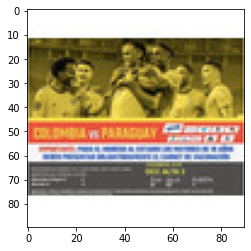

In [ ]:
# Se revisan algunas imágenes guardadas
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread(path_save_images+ '/img_8154.png')
imgplot = plt.imshow(img)
plt.show()

In [ ]:
list_images[27642]

'No tiene foto'

#### Vectorización de imágenes

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
import numpy as np
import pandas as pd
import cv2
from tqdm.auto import tqdm
import os
from matplotlib import pyplot as plt

In [ ]:
%matplotlib inline
def return_image_embedding(model,img):
    #img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img) # 
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x) # The images are converted from RGB to BGR, then each color channel is zero-centered with respect to the ImageNet dataset, without scaling.
    preds = model.predict(x)
    curr_df = pd.DataFrame(preds[0]).T
    return curr_df
model = ResNet50(include_top=False, weights='imagenet', pooling='avg') # ResNet-50 is a convolutional neural network that is 50 layers deep. You can load a pretrained version of the network trained on more than a million images from the ImageNet database. The pretrained network can classify images into 1000 object categories, such as keyboard, mouse, pencil, and many animals. 


94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
return_image_embedding(model,list_images[410])

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,2.795843,0.0,0.619721,0.0,1.135664,0.625997,0.0,2.828371,0.915975,0.0,...,0.0,0.3997,0.0,0.0,4.247299,0.036895,0.292101,0.0,0.224736,0.838097


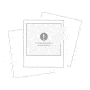

In [ ]:
list_images[410]

In [ ]:
# Se crea base con todas las vectorizaciones de las imágenes
embedding_df = pd.DataFrame()
start_time = time.time()
for idx, curr_img in enumerate(list_images):
  if (idx/5000).is_integer():
    print(idx)
  if curr_img != 'No tiene foto':
    try:
      curr_df = return_image_embedding(model,curr_img)
      curr_df['image'] = curr_img
      curr_df['index'] = idx
      embedding_df = pd.concat([embedding_df,curr_df],ignore_index=True)
    except Exception: 
      pass
print("--- %s seconds ---" % (time.time() - start_time))    
embedding_df.head(5)

0
5000
10000
15000
20000
25000
--- 4319.958447694778 seconds ---


,0,1,2,3,4,5,6,7,8,9,...,2040,2041,2042,2043,2044,2045,2046,2047,image,index
0,0.000000,2.357253,0.144611,0.329063,0.035845,0.000000,0.000000,0.057932,0.128690,0.000000,...,0.275088,0.313355,0.076232,0.000000,0.035970,0.000000,0.000000,0.000000,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0
1,0.814539,1.069026,0.839783,0.000000,2.571300,0.571394,0.000000,0.000000,0.100587,0.000000,...,0.048205,1.213464,0.000000,0.000000,1.165832,0.000000,0.000000,0.080701,<PIL.JpegImagePlugin.JpegImageFile image mode=...,1
2,0.088858,1.534596,0.933007,1.542011,0.278723,0.000000,0.606053,0.000000,0.000000,0.032546,...,0.326809,0.714751,0.131151,1.028456,1.207271,0.000000,0.000000,0.000000,<PIL.JpegImagePlugin.JpegImageFile image mode=...,2
3,0.438894,0.017106,0.000000,0.000000,0.000000,0.000000,0.000000,0.125173,0.037640,0.619372,...,5.011164,0.243343,0.000000,0.000000,0.129498,0.017608,0.000000,0.000000,<PIL.JpegImagePlugin.JpegImageFile image mode=...,3
4,0.636303,4.504492,0.000000,0.098480,0.000000,2.091979,0.000000,0.000000,0.169661,0.000000,...,0.000000,0.000000,0.000000,0.073148,0.000000,0.742315,3.428532,0.000000,<PIL.JpegImagePlugin.JpegImageFile image mode=...,4


In [ ]:
# Se guarda la base de embeddings de imágenes
embedding_df.columns = ['emb_img_'+str(col) for col in embedding_df.columns]
embedding_df.to_csv(path_save+'/img_emmbedding.csv')

In [15]:
############### Lectura intermedia de embeddings imágenes ###############

embedding_df = pd.read_csv(path_save+'/img_emmbedding.csv')
embedding_df = embedding_df.rename(columns={'Unnamed: 0': 'index'})
embedding_df.head()

,index,emb_img_0,emb_img_1,emb_img_2,emb_img_3,emb_img_4,emb_img_5,emb_img_6,emb_img_7,emb_img_8,...,emb_img_2040,emb_img_2041,emb_img_2042,emb_img_2043,emb_img_2044,emb_img_2045,emb_img_2046,emb_img_2047,emb_img_image,emb_img_index
0,0,0.000000,2.357253,0.144611,0.329063,0.035845,0.000000,0.000000,0.057932,0.128690,...,0.275088,0.313355,0.076232,0.000000,0.035970,0.000000,0.000000,0.000000,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0
1,1,0.814539,1.069025,0.839783,0.000000,2.571300,0.571394,0.000000,0.000000,0.100587,...,0.048205,1.213464,0.000000,0.000000,1.165832,0.000000,0.000000,0.080701,<PIL.JpegImagePlugin.JpegImageFile image mode=...,1
2,2,0.088858,1.534596,0.933007,1.542011,0.278723,0.000000,0.606053,0.000000,0.000000,...,0.326809,0.714751,0.131151,1.028456,1.207271,0.000000,0.000000,0.000000,<PIL.JpegImagePlugin.JpegImageFile image mode=...,2
3,3,0.438894,0.017106,0.000000,0.000000,0.000000,0.000000,0.000000,0.125173,0.037640,...,5.011164,0.243343,0.000000,0.000000,0.129498,0.017608,0.000000,0.000000,<PIL.JpegImagePlugin.JpegImageFile image mode=...,3
4,4,0.636303,4.504492,0.000000,0.098480,0.000000,2.091979,0.000000,0.000000,0.169661,...,0.000000,0.000000,0.000000,0.073148,0.000000,0.742315,3.428532,0.000000,<PIL.JpegImagePlugin.JpegImageFile image mode=...,4


In [79]:
# Revisión diferencia de índices en base total y base de imágenes
print(max(embedding_df['emb_img_index']), max(embedding_df['index']))

28973 28965


### Modelo KNN para imágenes
Se buscarán los n vecinos más cercanos de sobre los embeddings de las imágenes.

In [80]:
# Indices base nueva vs indices de siempre
traduccion_indices_img =  embedding_df[['index', 'emb_img_index']]
# Se toma data y se le pega el índice de las imágenes
data_temp_img = df_process[['id', 'title','name_cat']].reset_index()
#traduccion_indices_img = traduccion_indices_img.rename(columns={'index':'index_img', 'emb_img_index':'index'})

data_temp_img = data_temp_img.merge(traduccion_indices_img, on='index', how='left')
data_temp_img.head()


,index,id,title,name_cat,emb_img_index
0,0,MCO464124554,combo 2 forros protector sillas carro auto mascota perro,Accesorios para Vehículos,0.0
1,1,MCO558498519,palanca silla renault twingo clio megane x 2 color gris,Accesorios para Vehículos,1.0
2,2,MCO559508714,carpa pijama semi impermeable para moto con argolla metalica,Accesorios para Vehículos,2.0
3,3,MCO865524965,radio para carro jdl 5303 con usb bluetooth y lector de tarjeta sd,Accesorios para Vehículos,3.0
4,4,MCO844377861,pato para carro moto bicicleta accesorio de lujo,Accesorios para Vehículos,4.0


In [81]:
print(data_temp_img[data_temp_img['emb_img_index'].notna()].shape, data_temp_img.shape)

(28966, 5) (28974, 5)


In [83]:
# Función que imprime accuracy para imágenes
data_dic = data_temp_img[data_temp_img['emb_img_index'].notna()]
intento_dict = dict(zip(data_dic.index.astype(int), data_dic.emb_img_index))
index_nona = intento_dict.values()
def print_metrics_images(df,num_neigh, indices_model):
  y_test = df['name_cat']
  indices_neigh_img = [ind[num_neigh] for ind in indices_model]
  indices_neigh_reales = [intento_dict[ind_img] for ind_img in indices_neigh_img]
  y_pred = [df.loc[indice,'name_cat'] for indice in indices_neigh_reales]
  y_test = df.loc[index_nona,'name_cat']
  
  print(f'Accuracy neigh {num_neigh}: %.3f' % accuracy_score(y_test, y_pred))

In [ ]:
# Imprime tiempo y accuracy de cada knn entrenado con métrica y algoritmo distinto
metrics = ['cosine', 'euclidean']
algs = ['ball_tree', 'kd_tree', 'brute']
start_time_tot = time.time()
k_neighbors = 4 # Si se quieren n neighbors, se debe poner n+1
input_imgs = embedding_df[[i for i in embedding_df.columns if i not in ['emb_img_image', 'emb_img_index', 'index']]]
df= input_imgs
for algorithm in algs:
  for metric in metrics:
    try:
      indices, distances = knn_fit(metric, algorithm, k_neighbors, df)
      for i in range(3):
        print_metrics_images(df_process,i, indices)
    except:
      pass

print("--- %s seconds ---" % (time.time() - start_time_tot))


--- 1746.5088107585907 seconds --- euclidean ball_tree
Accuracy neigh 0: 0.546
Accuracy neigh 1: 0.455
Accuracy neigh 2: 0.413
--- 2229.321442604065 seconds --- euclidean kd_tree
Accuracy neigh 0: 0.546
Accuracy neigh 1: 0.455
Accuracy neigh 2: 0.413
--- 156.10363006591797 seconds --- cosine brute
Accuracy neigh 0: 0.565
Accuracy neigh 1: 0.474
Accuracy neigh 2: 0.435
--- 144.17670345306396 seconds --- euclidean brute
Accuracy neigh 0: 0.546
Accuracy neigh 1: 0.454
Accuracy neigh 2: 0.414
--- 4345.793936014175 seconds ---


In [84]:
# Se escoge metric cosine y algorithm brute por accuracy y tiempo.
import pickle
start_time = time.time()
input_imgs = embedding_df[[i for i in embedding_df.columns if i not in ['emb_img_image', 'emb_img_index', 'index']]]
k_neighbors=4 # Si se quieren n vecinos, se debe escoger n+1
metric = 'cosine'
algorithm='brute'
knn_text = NearestNeighbors(n_neighbors=k_neighbors,
                         metric=metric,
                         algorithm=algorithm,
                         n_jobs=-1)
neighs_img = knn_text.fit(input_imgs)
distances_img, indices_img = neighs_img.kneighbors(input_imgs)
# Se quitan los índices y las distancias de sus mismos productos
indices_img_new = [np.delete(indices_img[ind], (indices_img[ind]==ind).argmax()) for ind in range(len(indices_img))]
distances_img_new = [np.delete(distances_img[ind], (indices_img[ind]==ind).argmax()) for ind in range(len(distances_img))]

# Se guardan estos índices y distancias
pd.DataFrame(indices_img_new).to_csv(path_save + f'/models/indices_knn_img_{k_neighbors-1}_{metric}_{algorithm}.csv')
pd.DataFrame(distances_img_new).to_csv(path_save + f'/models/distances_knn_img_{k_neighbors-1}_{metric}_{algorithm}.csv')

# Se guarda modelo
filename = path_save+f'/models/knn_img_{k_neighbors-1}_{metric}_{algorithm}.sav'
pickle.dump(neighs_img, open(filename, 'wb'))


print_metrics_images(df_process,0, indices_img_new)

print("--- %s seconds ---" % (time.time() - start_time))

Accuracy neigh 0: 0.565
--- 146.42511653900146 seconds ---


In [111]:
# Se guarda base con los resultados de los 3 vecinos más cercanos para cada título
def resultados_knn_imagen(df_total, diccionario_indices,indices_modelo, distancias_modelo, 
                        title=1, # 1 si se quiere agregar título a la base, 0 si no.
                        categoria=1, # 1 si se quiere agregar categoría a la base, 0 si no.
                        imagen =1):# 1 si se quiere agregar imagen a la base, 0 si no.
  data_temp_tit = df_total[['id', 'title','id_cat','name_cat', 'thumbnail']]
  for ind in range(len(indices_modelo)):
    indices_knn = indices_modelo[ind]
    ind_real_general = diccionario_indices[ind]
    for idx,neigh in enumerate(indices_knn):
      index_real_neigh = diccionario_indices[neigh]
      id_neigh = df_total.loc[neigh, 'id']
      data_temp_tit.loc[ind, f'id_knn_{idx}'] = id_neigh
      data_temp_tit.loc[ind, f'distance_knn_{idx}'] = distancias_modelo[ind][idx]
      if title == 1:
        title_neigh = df_total.loc[neigh, 'title']
        data_temp_tit.loc[ind, f'title_knn_{idx}'] = title_neigh
      if categoria == 1:
        cat_neigh = df_total.loc[neigh, 'name_cat']
        data_temp_tit.loc[ind, f'cat_knn_{idx}'] = cat_neigh
      if imagen == 1:
        pic_neigh = df_total.loc[neigh, 'thumbnail']
        data_temp_tit.loc[ind, f'img_knn_{idx}'] = pic_neigh

  return data_temp_tit
index_nona = intento_dict.values() 
df_process_img = df_process.loc[index_nona,:].reset_index(drop=True)
resultados_img = resultados_knn_imagen(df_process_img, intento_dict,indices_img_new, distances_img_new, title=1, categoria=1, imagen =1) 
# Guarda para la posteridad
nombre_modelo = f'knn_img_{k_neighbors-1}_{metric}_{algorithm}'
resultados_img.to_csv(path_save +f'/models/resultados_{nombre_modelo}.csv', index=False) 
resultados_img.head()  


,id,title,id_cat,name_cat,thumbnail,id_knn_0,distance_knn_0,title_knn_0,cat_knn_0,img_knn_0,id_knn_1,distance_knn_1,title_knn_1,cat_knn_1,img_knn_1,id_knn_2,distance_knn_2,title_knn_2,cat_knn_2,img_knn_2
0,MCO464124554,combo 2 forros protector sillas carro auto mascota perro,MCO1747,Accesorios para Vehículos,http://http2.mlstatic.com/D_646062-MCO43036011644_082020-I.jpg,MCO563386482,1.193843e-01,combo 3 forros protectores sillas carro auto mascota perro,Accesorios para Vehículos,http://http2.mlstatic.com/D_689792-MCO43035861731_082020-I.jpg,MCO879503957,0.277271,set de construccion lego star wars the mandalorian the child 295 piezas en caja,Juegos y Juguetes,http://http2.mlstatic.com/D_870028-MLA48956815382_012022-I.jpg,MCO593463387,0.294541,taladro 3 8 perc 20v 2 veloc black decker bcd704c1 b3,Herramientas,http://http2.mlstatic.com/D_914089-MCO48250246384_112021-I.jpg
1,MCO558498519,palanca silla renault twingo clio megane x 2 color gris,MCO1747,Accesorios para Vehículos,http://http2.mlstatic.com/D_926680-MCO41388127411_042020-I.jpg,MCO565145403,7.771561e-16,manija palanca reclinar ajustar silla renault twingo,Accesorios para Vehículos,http://http2.mlstatic.com/D_715282-MCO42073140471_062020-I.jpg,MCO587090275,0.265684,manija techo nissan frontier importada,Accesorios para Vehículos,http://http2.mlstatic.com/D_820992-MCO43719052504_102020-I.jpg,MCO648002063,0.291492,llave lavamanos push cromada en caja ht80335,Construcción,http://http2.mlstatic.com/D_890262-MCO48692491159_122021-I.jpg
2,MCO559508714,carpa pijama semi impermeable para moto con argolla metalica,MCO1747,Accesorios para Vehículos,http://http2.mlstatic.com/D_609767-MCO48895331763_012022-I.jpg,MCO594166751,4.435935e-02,carpa semi permeable para moto talla l,Accesorios para Vehículos,http://http2.mlstatic.com/D_904984-MCO48934849778_012022-I.jpg,MCO637014691,0.054323,forro moto con argolla antirrobo soporta lluvia y sol xl,Accesorios para Vehículos,http://http2.mlstatic.com/D_623680-MCO48935318508_012022-I.jpg,MCO603155651,0.273720,botas oakley hombre,Ropa y Accesorios,http://http2.mlstatic.com/D_768351-MCO48014592693_102021-I.jpg
3,MCO865524965,radio para carro jdl 5303 con usb bluetooth y lector de tarjeta sd,MCO1747,Accesorios para Vehículos,http://http2.mlstatic.com/D_799836-MLA48110981644_112021-I.jpg,MCO531060824,1.311375e-01,radio para carro bluetooth usb micro sd auxiliar 3 5mm 50x4,Accesorios para Vehículos,http://http2.mlstatic.com/D_768845-MCO49579774582_042022-I.jpg,MCO605775692,0.202481,radio carro aiwa bluetooth usb 7 colores app android desmont,Accesorios para Vehículos,http://http2.mlstatic.com/D_620509-MCO49402397012_032022-I.jpg,MCO889033965,0.219967,kit ocb papel liar filtros tips hornet ultra thin paper,Otras categorías,http://http2.mlstatic.com/D_624093-MCO49838033221_052022-I.jpg
4,MCO844377861,pato para carro moto bicicleta accesorio de lujo,MCO1747,Accesorios para Vehículos,http://http2.mlstatic.com/D_620298-MCO49130427629_022022-I.jpg,MCO594025295,3.050995e-01,guitarra electrica persian tipo jazz,Instrumentos Musicales,http://http2.mlstatic.com/D_993072-MCO44042493236_112020-I.jpg,MCO597222003,0.332971,mochila astronauta viaje bolso guacal morral gato perro,Animales y Mascotas,http://http2.mlstatic.com/D_604391-MCO51446098777_092022-I.jpg,MCO829979793,0.334145,decoracion globos grado graduado graduacion toga birrete,"Recuerdos, Piñatería y Fiestas",http://http2.mlstatic.com/D_805261-MCO48164483566_112021-I.jpg


In [116]:
# Función toma embeddings de texto para indices de categoria
def embeddings_img_categoria(df_embeddings, df_total,categoria):
  indices_total = indices_categoria_total(df_total, categoria)
  indices_imag = [ind for ind in intento_dict if intento_dict[ind] in indices_total]
  emb_cat = df_embeddings.loc[indices_imag]
  return emb_cat

In [119]:
# Búsqueda de vecinos dentro de cada categoría Electrónica, Audio y Video
id_cat = 'MCO1000'
emb_prueba = embeddings_texto_categoria(input_imgs, resultados_img,id_cat)

mod_cat_text = knn_text.fit(emb_prueba)
dist_prueba, ind_prueba = mod_cat_text.kneighbors(emb_prueba)

ind_prueba_new = [np.delete(ind_prueba[ind], (ind_prueba[ind]==ind).argmax()) for ind in range(len(ind_prueba))]
dist_prueba_new = [np.delete(dist_prueba[ind], (ind_prueba[ind]==ind).argmax()) for ind in range(len(dist_prueba))]

base_cat = resultados_img[resultados_img['id_cat']==id_cat].reset_index(drop=True)
resultdos_prueba = resultados_knn_imagen(base_cat, intento_dict,ind_prueba_new, dist_prueba_new, title=1, categoria=0, imagen =1) 
#resultdos_prueba = resultdos_prueba[resultdos_prueba['id_knn_0'].notna()]
print(resultdos_prueba.shape)
# Revision muestra 50 predicciones
pd.options.display.max_colwidth = 100
resultdos_prueba.head(50)[['title', 'title_knn_0', 'title_knn_1']]

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(980, 17)


,title,title_knn_0,title_knn_1
0,audifonos in ear inalambricos xiaomi redmi airdots negro,audifonos in ear inalambricos sony wf c500 negro,audifonos in ear inalambricos skullcandy sesh true wireless earbuds negro
1,smart tv samsung series 5 un40t5290akxzl led full hd 40 100v 240v,smart tv samsung series 5 un43t5300afxzx led full hd 43 110v 127v,smart tv samsung series 5 un43t5300akxzl led full hd 43 100v 240v
2,audifonos in ear inalambricos f9 5 negro,audifonos in ear inalambricos f9 5 blanco,audifonos in ear inalambricos f9 negro
3,smart tv hyundai hyled3248aim hd 32 220v,smart tv hyundai hyled4321aim full hd 43 100v 200v,televisor hyundai 50 smart 4k android by google
4,audifonos in ear gamer inalambricos xiaomi redmi airdots 2 negro,audifonos in ear inalambricos bose quietcomfort earbuds triple black,audifonos in ear inalambricos xiaomi redmi airdots negro
5,amazon echo dot 4th gen con asistente virtual alexa charcoal 110v 240v,amazon echo 4th gen con asistente virtual alexa charcoal 110v 240v,amazon echo dot 4th gen con asistente virtual alexa twilight blue 110v 240v
6,google chromecast 3 generacion full hd carbon,audifonos sony bluetooth noise cancelling wh 1000xm5,audifonos inalambricos sony wh ch710n negro
7,roku express 4k 3941 de voz 4k negro,roku express 4k 3940 estandar 4k negro,roku express 3930 se estandar full hd 32mb con 512mb
8,audifonos in ear jbl tune 110 black,audifonos in ear jbl tune 110 blue,audifonos in ear jbl tune 110 white
9,amazon fire tv stick lite de voz full hd 8gb negro con 1gb de memoria ram,control remoto compatible con smart tv samsung bn59 01259b,control remoto compatible con samsung bn59 01310a one remote


In [121]:
# Búsqueda de vecinos dentro de cada categoría Inmuebles
id_cat = 'MCO1459'
emb_prueba = embeddings_texto_categoria(input_imgs, resultados_img,id_cat)

mod_cat_text = knn_text.fit(emb_prueba)
dist_prueba, ind_prueba = mod_cat_text.kneighbors(emb_prueba)

ind_prueba_new = [np.delete(ind_prueba[ind], (ind_prueba[ind]==ind).argmax()) for ind in range(len(ind_prueba))]
dist_prueba_new = [np.delete(dist_prueba[ind], (ind_prueba[ind]==ind).argmax()) for ind in range(len(dist_prueba))]

base_cat = resultados_img[resultados_img['id_cat']==id_cat].reset_index(drop=True)
resultdos_prueba = resultados_knn_imagen(base_cat, intento_dict,ind_prueba_new, dist_prueba_new, title=1, categoria=0, imagen =1) 
#resultdos_prueba = resultdos_prueba[resultdos_prueba['id_knn_0'].notna()]
print(resultdos_prueba.shape)
# Revision muestra 50 predicciones
pd.options.display.max_colwidth = 100
resultdos_prueba.head(50)[['title', 'title_knn_0', 'title_knn_1']]

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(1000, 17)


,title,title_knn_0,title_knn_1
0,apartamento en la verde 2 habitaciones 42 m,apartamento en villa clemencia 3 habitaciones 52 m,apartamento en venta alta suiza 2790 24379
1,venta de espectacular penthouse poblado para estrenar con jacuzzi,casa en cerezos i 9 habitaciones 247 m,venta de casa finca campestre a 10 minutos de niquia excelente clima
2,venta apartamento san antonio de prado,venta casa enea manizales codigo 4899360,apartamento en granada 1 habitacion 30 m
3,apartamento en union la flora 3 habitaciones 53 m,venta casa 2 niveles el poblado parte alta,casa finca bien iluminada en muy buen estado se vende a puerta cerrada
4,casa en barrio santa fe 5 habitaciones 167 m,apartamento en flandes fontibon 2 habitaciones 45 m,casa en senderos de funza 3 habitaciones 57 m
5,casa en perpetuo socorro 7 habitaciones 60 m,apartamento en venta en cali junin,apartamento en calatrava niza 2 habitaciones 65 m
6,apartamento en la rosita 2 habitaciones 20 m,apartamento en villemar 3 habitaciones 85 m,venta apartamento duplex en medellin laureles
7,apartamento en santa barbara central 3 habitaciones 120 m,apartamento en villemar 2 habitaciones 80 m,acogedor apartamento envigado el esmeraldal
8,casa en colina campestre niza 4 habitaciones 180 m,venta apartamento envigado la paz edificion nubenzza con espetacular vista oriente central 84 m2,hermosa finca para estrenar
9,apartamento en venta edificio moratto p h itaguih b,apartamento en venta edificio moratto p h itaguih b,apartamento en luis carlos galan minuto de dios 2 habitaciones 40 m


In [124]:
# Búsqueda de vecinos dentro de cada categoría Cámaras y Accesorios
id_cat = 'MCO1039'
emb_prueba = embeddings_texto_categoria(input_imgs, resultados_img,id_cat)

mod_cat_text = knn_text.fit(emb_prueba)
dist_prueba, ind_prueba = mod_cat_text.kneighbors(emb_prueba)

ind_prueba_new = [np.delete(ind_prueba[ind], (ind_prueba[ind]==ind).argmax()) for ind in range(len(ind_prueba))]
dist_prueba_new = [np.delete(dist_prueba[ind], (ind_prueba[ind]==ind).argmax()) for ind in range(len(dist_prueba))]

base_cat = resultados_img[resultados_img['id_cat']==id_cat].reset_index(drop=True)
resultdos_prueba = resultados_knn_imagen(base_cat, intento_dict,ind_prueba_new, dist_prueba_new, title=1, categoria=0, imagen =1) 
#resultdos_prueba = resultdos_prueba[resultdos_prueba['id_knn_0'].notna()]
print(resultdos_prueba.shape)
# Revision muestra 50 predicciones
pd.options.display.max_colwidth = 100
resultdos_prueba.head(50)[['title','thumbnail', 'title_knn_0','img_knn_0', 'title_knn_1']]

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(995, 17)


,title,thumbnail,title_knn_0,img_knn_0,title_knn_1
0,camara gopro hero10 5 3k chdhx 101 ntsc pal negra,http://http2.mlstatic.com/D_898554-MLA51321157595_082022-I.jpg,camara gopro hero9 5k chdhx 901 ntsc pal negra,http://http2.mlstatic.com/D_953917-MLA51045674653_082022-I.jpg,4k60fps ultra alta definicion wifi camara de accion de panta
1,tarjeta de memoria adata ausdx64guicl10 ra1 premier con adaptador sd 64gb,http://http2.mlstatic.com/D_724870-MLA45731900086_042021-I.jpg,tarjeta de memoria adata ausdh32guicl10 ra1 premier con adaptador sd 32gb,http://http2.mlstatic.com/D_818576-MLA45731625708_042021-I.jpg,tarjeta de memoria adata ausdh16guicl10 ra1 premier con adaptador sd 16gb
2,nikon coolpix b500 compacta avanzada color negro,http://http2.mlstatic.com/D_972164-MLA45730878331_042021-I.jpg,camara nikon b500 coolpix 16 mp 40x zoom full hd wifi,http://http2.mlstatic.com/D_705430-MCO31026724841_062019-I.jpg,camara nikon b500 coolpix 16 mp 40x zoom full hd wifi 16gb
3,drone dji mavic air 2s drdji023 fly more combo con camara 5 4k gris 3 baterias,http://http2.mlstatic.com/D_868520-MLA46306279338_062021-I.jpg,drone dji mavic air 2 drdji016 fly more combo con camara 4k gris 3 baterias,http://http2.mlstatic.com/D_923198-MLA47978874985_102021-I.jpg,dji mavic air 2 drone profesional quadcopter video 4k hdr
4,camara gopro hero9 5k chdhx 901 ntsc pal negra,http://http2.mlstatic.com/D_953917-MLA51045674653_082022-I.jpg,camara gopro hero10 5 3k chdhx 101 ntsc pal negra,http://http2.mlstatic.com/D_898554-MLA51321157595_082022-I.jpg,camara gopro hero5 4k chdhx 502 ntsc pal negra
5,tarjeta de memoria sandisk sdsquar 128g gn6mn ultra con adaptador sd 128gb,http://http2.mlstatic.com/D_776100-MLA45731824353_042021-I.jpg,tarjeta de memoria sandisk sdsquar 128g gn6mn ultra 128gb,http://http2.mlstatic.com/D_612631-MLA45731999640_042021-I.jpg,tarjeta de memoria sandisk sdsquar 200g gn6ma ultra con adaptador sd 200gb
6,sony kit alpha 6400 lente selp1650 ilce 6400l sin espejo color negro,http://http2.mlstatic.com/D_881317-MLA45730875178_042021-I.jpg,sony alpha 7c ilce 7c compacta color negro,http://http2.mlstatic.com/D_840540-MLA45730875743_042021-I.jpg,videocamara akaso v50 pro 4k ntsc pal gray
7,videocamara sony handycam hdr cx405 full hd ntsc pal negra,http://http2.mlstatic.com/D_666060-MLA42925175683_072020-I.jpg,grabacion de video hd sony videocamara hdcx405 handycam,http://http2.mlstatic.com/D_616650-MCO49200992338_022022-I.jpg,video camara hd aigo ahd s88
8,drone dji fpv combo con camara 4k void grey 1 bateria,http://http2.mlstatic.com/D_933680-MLA48481280751_122021-I.jpg,drone dji mavic air 2s drdji022 single con camara 5 4k gris 5 8ghz 1 bateria,http://http2.mlstatic.com/D_898637-MLA46233140017_062021-I.jpg,drone dji mavic pro con camara c4k gray 5ghz 1 bateria
9,tarjeta de memoria sandisk sdsqunr 064g gn3ma ultra con adaptador sd 64gb,http://http2.mlstatic.com/D_926971-MLA45732121864_042021-I.jpg,sandisk ultra tarjeta micro sdxc 64gb uhs i c10 100mb s,http://http2.mlstatic.com/D_965963-MCO49195579521_022022-I.jpg,tarjeta de memoria sandisk sdsqunr 128g gn6ta ultra con adaptador sd 128gb


In [ ]:
import plotly.express as px
fig = px.box(distances_img, y="distance_knn_0")
print(distances_img['distance_knn_0'].min(), distances_img['distance_knn_0'].max())
fig.show()

In [21]:
# Se revisa distribución de distancias para vecino 0 de imágenes
dist_img = distances_img['distance_knn_0']
norm_dis_img = (dist_img-dist_img.mean())/dist_img.std()
fig = px.box( y=norm_dis_img)
print(norm_dis_img.min(), norm_dis_img.max())
fig.show()

-1.6767839948086554 3.399969162661876


In [22]:
# Se revisa distribución de distancias para vecino 0 de textos
dist_text = distances_text['distance_knn_0']
norm_dist_text = (dist_text-dist_text.mean())/dist_text.std()
fig = px.box( y=norm_dist_text)
print(norm_dist_text.min(), norm_dist_text.max())
fig.show()

-0.4329963512461221 48.662904403891616


In [19]:
import plotly.express as px
fig = px.box(distances_text, y="distance_knn_0")
print(distances_text['distance_knn_0'].min(), distances_text['distance_knn_0'].max())
fig.show()

0.0 0.861504185775943


In [ ]:
######### Lectura intermedia de índices y distancias para imágenes #########
path_save= '/content/gdrive/MyDrive/reto_MeLi/outputs'
indices_img = pd.read_csv(path_save + 'indices_knn_images.csv')
indices_img.drop(columns=['Unnamed: 0'], inplace=True)
distances_img = pd.read_csv(path_save + 'distances_knn_images.csv')
distances_img.drop(columns=['Unnamed: 0'], inplace=True)
indices_img

,0,1,2,3
0,0,113,21534,17205
1,1,266,778,13463
2,2,57,228,26209
3,3,688,28383,28653
4,4,20490,3652,24712
...,...,...,...,...
28941,28941,4738,4133,2869
28942,28942,14167,6021,2492
28943,28943,20028,27364,19999
28944,28944,5600,5511,5539


## Ensamble modelos

Se crea un ensamble de los modelos de texto e imágenes (creados por separado) bajo dos reglas específicas:

* Se respeta vecino y su posición si la distancia entre las imágenes es 0.
* Se respeta orden de vecinos de texto y se llenan los espacios de vecinos que no quedaron con distancia 0 de imágenes.

In [126]:
#pd.DataFrame(indices_img_new).to_csv(path_save + f'/models/indices_knn_img_{k_neighbors-1}_{metric}_{algorithm}.csv')
distancias_totales_imag = pd.read_csv(path_save + f'/models/distances_knn_img_{k_neighbors-1}_{metric}_{algorithm}.csv')
distancias_totales_text = pd.read_csv(path_save + f'/models/distances_knn_text_{k_neighbors-1}_{metric}_{algorithm}.csv')
distancias_totales_imag

,Unnamed: 0,0,1,2
0,0,1.193843e-01,0.277271,0.294541
1,1,7.771561e-16,0.265684,0.291492
2,2,4.435935e-02,0.054323,0.273720
3,3,1.311375e-01,0.202481,0.219967
4,4,3.050995e-01,0.332971,0.334145
...,...,...,...,...
28961,28961,2.349958e-01,0.253526,0.283904
28962,28962,1.548602e-01,0.173180,0.180386
28963,28963,2.863552e-01,0.310020,0.343731
28964,28964,4.435724e-01,0.445854,0.477523


In [128]:
fig = px.box(distancias_totales_text, y='0')
print(distancias_totales_text['0'].min(), distancias_totales_text['0'].max())
fig.show()

0.0 0.861504185775943


In [129]:
fig = px.box(distancias_totales_imag, y='0')
print(distancias_totales_imag['0'].min(), distancias_totales_imag['0'].max())
fig.show()

0.0 0.5850907379826222


In [25]:
################ Lectura intermedia resultados modelo general imágenes ################
nombre_modelo = f'knn_img_{k_neighbors-1}_{metric}_{algorithm}'
resultados_img = pd.read_csv(path_save +f'/models/resultados_{nombre_modelo}.csv') 
resultados_img.head()  


,id,title,id_cat,name_cat,thumbnail,id_knn_0,distance_knn_0,title_knn_0,cat_knn_0,img_knn_0,id_knn_1,distance_knn_1,title_knn_1,cat_knn_1,img_knn_1,id_knn_2,distance_knn_2,title_knn_2,cat_knn_2,img_knn_2
0,MCO464124554,combo 2 forros protector sillas carro auto mas...,MCO1747,Accesorios para Vehículos,http://http2.mlstatic.com/D_646062-MCO43036011...,MCO563386482,1.193843e-01,combo 3 forros protectores sillas carro auto m...,Accesorios para Vehículos,http://http2.mlstatic.com/D_689792-MCO43035861...,MCO879503957,0.277271,set de construccion lego star wars the mandalo...,Juegos y Juguetes,http://http2.mlstatic.com/D_870028-MLA48956815...,MCO593463387,0.294541,taladro 3 8 perc 20v 2 veloc black decker bcd7...,Herramientas,http://http2.mlstatic.com/D_914089-MCO48250246...
1,MCO558498519,palanca silla renault twingo clio megane x 2 c...,MCO1747,Accesorios para Vehículos,http://http2.mlstatic.com/D_926680-MCO41388127...,MCO565145403,7.771561e-16,manija palanca reclinar ajustar silla renault ...,Accesorios para Vehículos,http://http2.mlstatic.com/D_715282-MCO42073140...,MCO587090275,0.265684,manija techo nissan frontier importada,Accesorios para Vehículos,http://http2.mlstatic.com/D_820992-MCO43719052...,MCO648002063,0.291492,llave lavamanos push cromada en caja ht80335,Construcción,http://http2.mlstatic.com/D_890262-MCO48692491...
2,MCO559508714,carpa pijama semi impermeable para moto con ar...,MCO1747,Accesorios para Vehículos,http://http2.mlstatic.com/D_609767-MCO48895331...,MCO594166751,4.435935e-02,carpa semi permeable para moto talla l,Accesorios para Vehículos,http://http2.mlstatic.com/D_904984-MCO48934849...,MCO637014691,0.054323,forro moto con argolla antirrobo soporta lluvi...,Accesorios para Vehículos,http://http2.mlstatic.com/D_623680-MCO48935318...,MCO603155651,0.273720,botas oakley hombre,Ropa y Accesorios,http://http2.mlstatic.com/D_768351-MCO48014592...
3,MCO865524965,radio para carro jdl 5303 con usb bluetooth y...,MCO1747,Accesorios para Vehículos,http://http2.mlstatic.com/D_799836-MLA48110981...,MCO531060824,1.311375e-01,radio para carro bluetooth usb micro sd auxili...,Accesorios para Vehículos,http://http2.mlstatic.com/D_768845-MCO49579774...,MCO605775692,0.202481,radio carro aiwa bluetooth usb 7 colores app a...,Accesorios para Vehículos,http://http2.mlstatic.com/D_620509-MCO49402397...,MCO889033965,0.219967,kit ocb papel liar filtros tips hornet ultra t...,Otras categorías,http://http2.mlstatic.com/D_624093-MCO49838033...
4,MCO844377861,pato para carro moto bicicleta accesorio de lujo,MCO1747,Accesorios para Vehículos,http://http2.mlstatic.com/D_620298-MCO49130427...,MCO594025295,3.050995e-01,guitarra electrica persian tipo jazz,Instrumentos Musicales,http://http2.mlstatic.com/D_993072-MCO44042493...,MCO597222003,0.332971,mochila astronauta viaje bolso guacal morral g...,Animales y Mascotas,http://http2.mlstatic.com/D_604391-MCO51446098...,MCO829979793,0.334145,decoracion globos grado graduado graduacion to...,"Recuerdos, Piñatería y Fiestas",http://http2.mlstatic.com/D_805261-MCO48164483...


In [26]:
################ Lectura intermedia resultados modelo general texto ################
nombre_modelo = f'knn_text_{k_neighbors-1}_{metric}_{algorithm}'
resultados_text = pd.read_csv(path_save +f'/models/resultados_{nombre_modelo}.csv') 
resultados_text.head() 

,Unnamed: 0,id,title,id_cat,name_cat,thumbnail,id_knn_0,distance_knn_0,title_knn_0,cat_knn_0,...,id_knn_1,distance_knn_1,title_knn_1,cat_knn_1,img_knn_1,id_knn_2,distance_knn_2,title_knn_2,cat_knn_2,img_knn_2
0,0,MCO464124554,combo 2 forros protector sillas carro auto mas...,MCO1747,Accesorios para Vehículos,http://http2.mlstatic.com/D_646062-MCO43036011...,MCO563386482,0.000000e+00,combo 3 forros protectores sillas carro auto m...,Accesorios para Vehículos,...,MCO653809561,0.000000,combo 2 forros protectores sillas carro auto m...,Accesorios para Vehículos,http://http2.mlstatic.com/D_920358-MCO47010681...,MCO570531939,0.003094,forro silla delantero perro mascota protector ...,Accesorios para Vehículos,http://http2.mlstatic.com/D_617778-MCO42641124...
1,1,MCO558498519,palanca silla renault twingo clio megane x 2 c...,MCO1747,Accesorios para Vehículos,http://http2.mlstatic.com/D_926680-MCO41388127...,MCO590689575,3.826513e-03,palanca silla renault twingo clio megane x 2 c...,Accesorios para Vehículos,...,MCO571817833,0.024956,siilla gerencial,Industrias y Oficinas,http://http2.mlstatic.com/D_863060-MCO49471527...,MCO509643341,0.026729,silla giratoria premium presidente ergonomica ...,Industrias y Oficinas,http://http2.mlstatic.com/D_723254-MCO49773513...
2,2,MCO559508714,carpa pijama semi impermeable para moto con ar...,MCO1747,Accesorios para Vehículos,http://http2.mlstatic.com/D_609767-MCO48895331...,MCO576084004,9.996786e-04,carpa pijama impermeable para moto con argolla...,Accesorios para Vehículos,...,MCO594045530,0.006111,zapatones impermeables moto o bicicleta en lat...,Accesorios para Vehículos,http://http2.mlstatic.com/D_606244-MCO44310563...,MCO815597778,0.006473,carpa pijama semi impermeable para moto con ma...,Accesorios para Vehículos,http://http2.mlstatic.com/D_833071-MCO47699621...
3,3,MCO865524965,radio para carro jdl 5303 con usb bluetooth y...,MCO1747,Accesorios para Vehículos,http://http2.mlstatic.com/D_799836-MLA48110981...,MCO880053694,3.799770e-03,radio para carro bowmann ds 2700bt con usb blu...,Accesorios para Vehículos,...,MCO884057162,0.004349,radio para carro jdl 1210 con usb y lector de ...,Accesorios para Vehículos,http://http2.mlstatic.com/D_824089-MLA49169728...,MCO880028192,0.010030,radio para carro baxster cm1503ma con usb blue...,Accesorios para Vehículos,http://http2.mlstatic.com/D_634568-MLA48924350...
4,4,MCO844377861,pato para carro moto bicicleta accesorio de lujo,MCO1747,Accesorios para Vehículos,http://http2.mlstatic.com/D_620298-MCO49130427...,MCO844403817,2.220446e-16,pato para carro moto bicicleta accesorio de lujo,Accesorios para Vehículos,...,MCO585409410,0.008715,1 llavero resorte en espiral flexible universa...,Antigüedades y Colecciones,http://http2.mlstatic.com/D_906923-MCO43622942...,MCO452449731,0.010018,llavero casco moto miniatura escala metalico s...,Antigüedades y Colecciones,http://http2.mlstatic.com/D_682082-MCO41311913...


In [27]:
print(resultados_img.shape, resultados_text.shape)

(28966, 20) (28974, 21)


In [29]:
# Junta resultados de modelo texto y modelo imágenes
junte_resultados = resultados_img.merge(resultados_text, on=['id', 'title', 'id_cat', 'name_cat', 'thumbnail'], how='left')
# Cambio de nombre de algunas columnas
junte_resultados.columns = junte_resultados.columns.str.replace('_x', '_img')
junte_resultados.columns = junte_resultados.columns.str.replace('_y', '_text')
junte_resultados.head(2)

,id,title,id_cat,name_cat,thumbnail,id_knn_0_img,distance_knn_0_img,title_knn_0_img,cat_knn_0_img,img_knn_0_img,...,id_knn_1_text,distance_knn_1_text,title_knn_1_text,cat_knn_1_text,img_knn_1_text,id_knn_2_text,distance_knn_2_text,title_knn_2_text,cat_knn_2_text,img_knn_2_text
0,MCO464124554,combo 2 forros protector sillas carro auto mas...,MCO1747,Accesorios para Vehículos,http://http2.mlstatic.com/D_646062-MCO43036011...,MCO563386482,1.193843e-01,combo 3 forros protectores sillas carro auto m...,Accesorios para Vehículos,http://http2.mlstatic.com/D_689792-MCO43035861...,...,MCO653809561,0.000000,combo 2 forros protectores sillas carro auto m...,Accesorios para Vehículos,http://http2.mlstatic.com/D_920358-MCO47010681...,MCO570531939,0.003094,forro silla delantero perro mascota protector ...,Accesorios para Vehículos,http://http2.mlstatic.com/D_617778-MCO42641124...
1,MCO558498519,palanca silla renault twingo clio megane x 2 c...,MCO1747,Accesorios para Vehículos,http://http2.mlstatic.com/D_926680-MCO41388127...,MCO565145403,7.771561e-16,manija palanca reclinar ajustar silla renault ...,Accesorios para Vehículos,http://http2.mlstatic.com/D_715282-MCO42073140...,...,MCO571817833,0.024956,siilla gerencial,Industrias y Oficinas,http://http2.mlstatic.com/D_863060-MCO49471527...,MCO509643341,0.026729,silla giratoria premium presidente ergonomica ...,Industrias y Oficinas,http://http2.mlstatic.com/D_723254-MCO49773513...


In [33]:
print(junte_resultados[junte_resultados['distance_knn_0_img']==0].shape, junte_resultados[junte_resultados['distance_knn_1_img']==0].shape, junte_resultados[junte_resultados['distance_knn_2_img']==0].shape)
print(junte_resultados[junte_resultados['distance_knn_0_text']==0].shape, junte_resultados[junte_resultados['distance_knn_1_text']==0].shape, junte_resultados[junte_resultados['distance_knn_2_text']==0].shape)


(1224, 36) (282, 36) (108, 36)
(2713, 36) (1019, 36) (531, 36)


In [39]:
pd.options.display.max_colwidth = 100
junte_resultados[junte_resultados['distance_knn_0_text']==0][['title', 'thumbnail', 'title_knn_0_text', 'img_knn_0_text', 'distance_knn_0_text']]

,title,thumbnail,title_knn_0_text,img_knn_0_text,distance_knn_0_text
0,combo 2 forros protector sillas carro auto mascota perro,http://http2.mlstatic.com/D_646062-MCO43036011644_082020-I.jpg,combo 3 forros protectores sillas carro auto mascota perro,http://http2.mlstatic.com/D_689792-MCO43035861731_082020-I.jpg,0.0
16,radio carro bluetooth camara usb sd pantalla 7 hd mod 2020,http://http2.mlstatic.com/D_609214-MCO44055199470_112020-I.jpg,radio carro bluetooth camara usb sd pantalla 7 hd mod 2020,http://http2.mlstatic.com/D_624320-MCO31173845809_062019-I.jpg,0.0
28,letras reflectivas para casco moto placas reglamentarias,http://http2.mlstatic.com/D_836985-MCO49638655847_042022-I.jpg,letras reflectivas casco moto placas reglamentarias 2022,http://http2.mlstatic.com/D_698274-MCO49655913235_042022-I.jpg,0.0
32,protector puerta carro magnetico anti portazo rayon golpe x4,http://http2.mlstatic.com/D_921180-MLA46795018894_072021-I.jpg,protector puerta carro magnetico anti portazo rayon golpe x2,http://http2.mlstatic.com/D_656019-MCO45216892984_032021-I.jpg,0.0
34,escaner elm327 automotriz vehicular bluetooth obd2 carro,http://http2.mlstatic.com/D_689774-MCO44572655272_012021-I.jpg,escaner elm327 automotriz vehicular bluetooth obd2 carro,http://http2.mlstatic.com/D_639950-MCO31005876630_062019-I.jpg,0.0
...,...,...,...,...,...
28930,bong pipa de agua en vidrio 11cm mini narguile,http://http2.mlstatic.com/D_956013-MCO50055519846_052022-I.jpg,bong pipa de agua en vidrio 11cm mini narguile,http://http2.mlstatic.com/D_737399-MCO50055625618_052022-I.jpg,0.0
28933,crema a y d tarro x 300gr cuidado del tatuaje,http://http2.mlstatic.com/D_989876-MCO49088004472_022022-I.jpg,crema a y d tarro x 300gr cuidado del tatuaje,http://http2.mlstatic.com/D_756696-MCO49087782967_022022-I.jpg,0.0
28946,alcohol polivinilico 1 kilo,http://http2.mlstatic.com/D_781458-MCO43710842831_102020-I.jpg,alcohol polivinilico 4 kilo,http://http2.mlstatic.com/D_797904-MCO43710842070_102020-I.jpg,0.0
28950,netflix colombia tarjeta de regalo netflix 30000,http://http2.mlstatic.com/D_684158-MCO50929092208_072022-I.jpg,netflix colombia tarjeta de regalo netflix 50000,http://http2.mlstatic.com/D_879653-MCO43285461186_082020-I.jpg,0.0


In [40]:
junte_resultados.columns

Index(['id', 'title', 'id_cat', 'name_cat', 'thumbnail', 'id_knn_0_img',
       'distance_knn_0_img', 'title_knn_0_img', 'cat_knn_0_img',
       'img_knn_0_img', 'id_knn_1_img', 'distance_knn_1_img',
       'title_knn_1_img', 'cat_knn_1_img', 'img_knn_1_img', 'id_knn_2_img',
       'distance_knn_2_img', 'title_knn_2_img', 'cat_knn_2_img',
       'img_knn_2_img', 'Unnamed: 0', 'id_knn_0_text', 'distance_knn_0_text',
       'title_knn_0_text', 'cat_knn_0_text', 'img_knn_0_text', 'id_knn_1_text',
       'distance_knn_1_text', 'title_knn_1_text', 'cat_knn_1_text',
       'img_knn_1_text', 'id_knn_2_text', 'distance_knn_2_text',
       'title_knn_2_text', 'cat_knn_2_text', 'img_knn_2_text'],
      dtype='object')

In [56]:
# Crea función que genera ensamble de resultados bajo reglas
cantidad_neigh=3 
def resultados_ensamble(resultados_totales):
  resultados_new = resultados_totales[['id', 'title', 'id_cat', 'name_cat', 'thumbnail']]
  cols_img = [i for i in resultados_totales.columns if '_img' in i]
  cols_text = [i for i in resultados_totales.columns if '_text' in i]
  #######  Primera regla: Si la imagen es exactamente la misma, se respeta el vecino y el número ####### 
  
  for neigh in range(cantidad_neigh):
    columnas_tomar = [f'id_knn_{neigh}_',
       f'distance_knn_{neigh}_', f'title_knn_{neigh}_', f'cat_knn_{neigh}_',
       f'img_knn_{neigh}_']
    columnas_tomar_img = [i+'img' for i in columnas_tomar]+['id']
    knn = resultados_totales[resultados_totales[f'distance_knn_{neigh}_img']==0][columnas_tomar_img]
    knn.columns = knn.columns.str.replace('_img', '')
    resultados_new = resultados_new.merge(knn, on='id', how='left')
  
  ####### Vecinos de texto para los puestos que faltan llenar para generar 3 vecinos ####### 
  resultados_new['cuenta_temp'] = resultados_new.isnull().sum(axis=1)
  # Si hay un espacio vacío
  indices_tomar = resultados_new.loc[resultados_new['cuenta_temp']==5].index
  neigh= 2
  columnas_tomar = [f'id_knn_{neigh}',
       f'distance_knn_{neigh}', f'title_knn_{neigh}', f'cat_knn_{neigh}',
       f'img_knn_{neigh}']
  
  for col in columnas_tomar:
    resultados_new.loc[resultados_new['cuenta_temp']==5, col] = resultados_totales.loc[indices_tomar, col[:-1]+'0_text']

  # Si hay dos espacios
  indices_tomar = resultados_new.loc[resultados_new['cuenta_temp']==10].index
  neigh= 1
  columnas_tomar = [f'id_knn_{neigh}',
       f'distance_knn_{neigh}', f'title_knn_{neigh}', f'cat_knn_{neigh}',
       f'img_knn_{neigh}']
  
  for col in columnas_tomar:
    resultados_new.loc[resultados_new['cuenta_temp']==10, col] = resultados_totales.loc[indices_tomar, col[:-1]+'0_text']

  neigh= 2
  columnas_tomar = [f'id_knn_{neigh}',
       f'distance_knn_{neigh}', f'title_knn_{neigh}', f'cat_knn_{neigh}',
       f'img_knn_{neigh}']
  
  for col in columnas_tomar:
    resultados_new.loc[resultados_new['cuenta_temp']==10, col] = resultados_totales.loc[indices_tomar, col[:-1]+'1_text']

  # Si hay tres espacios
  indices_tomar = resultados_new.loc[resultados_new['cuenta_temp']==15].index

  for neigh in range(3):
    columnas_tomar = [f'id_knn_{neigh}',
       f'distance_knn_{neigh}', f'title_knn_{neigh}', f'cat_knn_{neigh}',
       f'img_knn_{neigh}']
    
    for col in columnas_tomar:
      resultados_new.loc[resultados_new['cuenta_temp']==15, col] = resultados_totales.loc[indices_tomar, col+'_text']


  return resultados_new

    



In [57]:
prueba = resultados_ensamble(junte_resultados)
#prueba[prueba['id_knn_0'].notna()]
prueba

,id,title,id_cat,name_cat,thumbnail,id_knn_0,distance_knn_0,title_knn_0,cat_knn_0,img_knn_0,...,distance_knn_1,title_knn_1,cat_knn_1,img_knn_1,id_knn_2,distance_knn_2,title_knn_2,cat_knn_2,img_knn_2,cuenta_temp
0,MCO464124554,combo 2 forros protector sillas carro auto mascota perro,MCO1747,Accesorios para Vehículos,http://http2.mlstatic.com/D_646062-MCO43036011644_082020-I.jpg,MCO563386482,0.000000e+00,combo 3 forros protectores sillas carro auto mascota perro,Accesorios para Vehículos,http://http2.mlstatic.com/D_689792-MCO43035861731_082020-I.jpg,...,0.000000,combo 2 forros protectores sillas carro auto mascota perro,Accesorios para Vehículos,http://http2.mlstatic.com/D_920358-MCO47010681880_082021-I.jpg,MCO570531939,0.003094,forro silla delantero perro mascota protector funda carro,Accesorios para Vehículos,http://http2.mlstatic.com/D_617778-MCO42641124054_072020-I.jpg,15
1,MCO558498519,palanca silla renault twingo clio megane x 2 color gris,MCO1747,Accesorios para Vehículos,http://http2.mlstatic.com/D_926680-MCO41388127411_042020-I.jpg,MCO590689575,3.826513e-03,palanca silla renault twingo clio megane x 2 color negra,Accesorios para Vehículos,http://http2.mlstatic.com/D_811612-MCO43826774574_102020-I.jpg,...,0.024956,siilla gerencial,Industrias y Oficinas,http://http2.mlstatic.com/D_863060-MCO49471527734_032022-I.jpg,MCO509643341,0.026729,silla giratoria premium presidente ergonomica marco blanco,Industrias y Oficinas,http://http2.mlstatic.com/D_723254-MCO49773513431_042022-I.jpg,15
2,MCO559508714,carpa pijama semi impermeable para moto con argolla metalica,MCO1747,Accesorios para Vehículos,http://http2.mlstatic.com/D_609767-MCO48895331763_012022-I.jpg,MCO576084004,9.996786e-04,carpa pijama impermeable para moto con argolla metalica,Accesorios para Vehículos,http://http2.mlstatic.com/D_914297-MCO49922115363_052022-I.jpg,...,0.006111,zapatones impermeables moto o bicicleta en latex bota,Accesorios para Vehículos,http://http2.mlstatic.com/D_606244-MCO44310563210_122020-I.jpg,MCO815597778,0.006473,carpa pijama semi impermeable para moto con maletero,Accesorios para Vehículos,http://http2.mlstatic.com/D_833071-MCO47699621543_092021-I.jpg,15
3,MCO865524965,radio para carro jdl 5303 con usb bluetooth y lector de tarjeta sd,MCO1747,Accesorios para Vehículos,http://http2.mlstatic.com/D_799836-MLA48110981644_112021-I.jpg,MCO880053694,3.799770e-03,radio para carro bowmann ds 2700bt con usb bluetooth y lector de tarjeta sd,Accesorios para Vehículos,http://http2.mlstatic.com/D_862912-MLA47791669818_102021-I.jpg,...,0.004349,radio para carro jdl 1210 con usb y lector de tarjeta sd,Accesorios para Vehículos,http://http2.mlstatic.com/D_824089-MLA49169728848_022022-I.jpg,MCO880028192,0.010030,radio para carro baxster cm1503ma con usb bluetooth y lector de tarjeta sd,Accesorios para Vehículos,http://http2.mlstatic.com/D_634568-MLA48924350315_012022-I.jpg,15
4,MCO844377861,pato para carro moto bicicleta accesorio de lujo,MCO1747,Accesorios para Vehículos,http://http2.mlstatic.com/D_620298-MCO49130427629_022022-I.jpg,MCO844403817,2.220446e-16,pato para carro moto bicicleta accesorio de lujo,Accesorios para Vehículos,http://http2.mlstatic.com/D_951963-MCO49054858836_022022-I.jpg,...,0.008715,1 llavero resorte en espiral flexible universal motos carros,Antigüedades y Colecciones,http://http2.mlstatic.com/D_906923-MCO43622942642_092020-I.jpg,MCO452449731,0.010018,llavero casco moto miniatura escala metalico souvenir carro,Antigüedades y Colecciones,http://http2.mlstatic.com/D_682082-MCO41311913510_042020-I.jpg,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28961,MCO532078902,5 grip desechable puntera y tubo tatuaje tattoo tatuaje,MCO1953,Otras categorías,http://http2.mlstatic.com/D_611551-MCO31969065368_082019-I.jpg,MCO580280479,1.237138e-02,cartuchos para tatuar,Otras categorías,http://http2.mlstatic.com/D_989233-MCO43325546627_082020-I.jpg,...,0.014755,stencil proton 1 5 oz tattoo tatuaje plantilla t

In [59]:
y_test = prueba['name_cat']

num_neigh = 0
y_pred = prueba[f'cat_knn_{num_neigh}']
print(f'Accuracy neigh {num_neigh}: %.3f' % accuracy_score(y_test, y_pred))
num_neigh = 1
y_pred = prueba[f'cat_knn_{num_neigh}']
print(f'Accuracy neigh {num_neigh}: %.3f' % accuracy_score(y_test, y_pred))
num_neigh = 2
y_pred = prueba[f'cat_knn_{num_neigh}']
print(f'Accuracy neigh {num_neigh}: %.3f' % accuracy_score(y_test, y_pred))

Accuracy neigh 0: 0.718
Accuracy neigh 1: 0.662
Accuracy neigh 2: 0.634


Las accuracies del **modelo ensamble** son: \\
Accuracy neigh 0: 0.718 \\
Accuracy neigh 1: 0.662 \\
Accuracy neigh 2: 0.634 \\

Recordemos las accuracies del **modelo de texto** solo: \\
Accuracy neigh 0: 0.716 \\
Accuracy neigh 1: 0.660 \\
Accuracy neigh 2: 0.631 \\

Recordemos las accuracies del **modelo de imagen** solo: \\
Accuracy neigh 0: 0.565 \\
Accuracy neigh 1: 0.474 \\
Accuracy neigh 2: 0.435 \\

Se puede concluir que mejora el accuracy en los tres vecinos y por lo tanto las reglas del ensamble funcionan.

# Fin del documento